In [791]:
# Standard libraries
import os
import calendar
import random
import math
import logging
import scipy
import pdb
import copy

import seaborn         as sns
import pandas          as pd
import numpy           as np
import datetime        as dt
import statsmodels.api as sm

from pandas     import datetime
from matplotlib import pyplot as plt
# GPR imports
from sklearn.gaussian_process  import GaussianProcessRegressor
from sklearn.gaussian_process  import kernels
# Preprocessing imports
from sklearn                   import preprocessing
from sklearn.preprocessing     import LabelEncoder
from sklearn.preprocessing     import MinMaxScaler
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split
# SVR import
from sklearn                   import svm
# Automated feature selection imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
# Regression metrics
from sklearn.metrics           import mean_squared_error
from sklearn.metrics           import r2_score
from sklearn.metrics           import mean_absolute_error

# XGBoost libraries
import xgboost
from   xgboost.sklearn         import XGBRegressor
# Pytorch imports
import  torch
from    torch                  import nn
from    torch                  import optim
from    torch.nn               import functional as F
from    torch.utils.data       import TensorDataset, DataLoader
from    torch                  import optim
from    torch.optim            import lr_scheduler
from    torch.autograd         import Variable 

# Autoregression plots
from statsmodels.graphics.tsaplots      import plot_acf, plot_pacf
# Misc imports
from __future__  import division, print_function, absolute_import
from collections import OrderedDict
from copy import deepcopy

plt.rcParams["figure.figsize"] = (45,20)
%matplotlib inline

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3736870613.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas     import datetime


In [2]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    "Mean Directional Accuracy"
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])))

In [847]:
# find households that share same consumption patterns
# read info households
path = os.getcwd()+"/data/informations_households.csv"
hh_info = pd.read_csv(path)


max_num = 100
block_nums = [85, 86,87] # comfortable, L

####
tot_num=0
path = os.getcwd()+"/data/hc_0.csv"
data = pd.read_csv(path)
ids = weather_energy_info.LCLid.unique()
tot_num = tot_num+len(ids)
tot_num = min(tot_num, max_num)


path = os.getcwd()+"/data/hc_0.csv"
data = pd.read_csv(path)
ids = data.LCLid.unique()

means_all=[]
hh_ids = []
for id in ids:
    # get df
    #print(data[data.LCLid == id])
    df_1p = weather_energy_info[weather_energy_info.LCLid == id]#get_data_of_a_person(block_num, id,crop_years=False)
#     if len(df_1p.date)<365*48:
#         print(str(id) + ' has less than 1 year of data')
#         continue
    means = df_1p.groupby('time', as_index=False)['energy'].mean()
    means = np.array(means.energy.values, dtype=float)
#     if len(means) != 48:
#         print('?')
#         continue
    if means.any():
        means_all.append(means)
    hh_ids.append(id)
    if len(hh_ids)==tot_num:
        break
tot_num = len(means_all)
    
# SELECT   
sel_num = 30
sel_num = min(sel_num, tot_num)

# manipulate!
# compute mean over all
means_av = means_all[0]
for i in np.arange(1,tot_num):
    means_av = means_av + means_all[i]
    
means_av = means_av/tot_num
devs = []
for i in np.arange(tot_num):
    devs.append(((means_all[i] - means_av) ** 2).mean(axis=0))
best_sub = sorted(range(len(devs)), key = lambda sub: devs[sub])[:sel_num]

# find best set of households
best_ids = [hh_ids[i] for i in list(best_sub)]
means_filt = [list(means_all[i]) for i in list(best_sub)]
print(list(best_sub))
print('Best ids', best_ids)

[3, 9, 7, 17, 10, 18, 28, 27, 12, 14, 35, 16, 25, 30, 40, 37, 34, 38, 33, 11, 20, 13, 5, 0, 8, 41, 22, 1, 42, 24]
Best ids ['MAC001074', 'MAC003348', 'MAC003281', 'MAC003463', 'MAC003388', 'MAC003482', 'MAC003680', 'MAC003668', 'MAC003400', 'MAC003423', 'MAC003805', 'MAC003449', 'MAC003646', 'MAC003718', 'MAC003856', 'MAC003826', 'MAC003775', 'MAC003844', 'MAC003740', 'MAC003394', 'MAC003557', 'MAC003422', 'MAC003239', 'MAC000002', 'MAC003305', 'MAC003863', 'MAC003579', 'MAC000246', 'MAC003874', 'MAC003613']


# Single household

In [848]:
# loading the data
alldata = pd.read_csv("data/hc_0.csv")

df = alldata.copy()
df.reset_index(drop=True, inplace=True)
df.head()

Unnamed: 0                         tstp      LCLid energy(kWh/hh)
0           0  2012-10-12 00:30:00.0000000  MAC000002             0 
1           1  2012-10-12 01:00:00.0000000  MAC000002             0 
2           2  2012-10-12 01:30:00.0000000  MAC000002             0 
3           3  2012-10-12 02:00:00.0000000  MAC000002             0 
4           4  2012-10-12 02:30:00.0000000  MAC000002             0

In [37]:
# converting timestamps into datetime format
df['tstp'] = df['tstp'].astype('datetime64[s]')

In [38]:
# adding time features
df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'tstp'], '%Y-%m-%d %H:%M:%S')
df.loc[:,'date'] = df.loc[:,'tstp'].dt.date
df.loc[:,'month'] = df.loc[:,'datetime'].dt.month
df.loc[:,'day_of_month'] = df.loc[:,'datetime'].dt.day
df.loc[:,'time'] = df.loc[:,'datetime'].dt.time
df.loc[:,'hour'] = df.loc[:,'datetime'].dt.hour
df.loc[:,'minute'] = df.loc[:,'datetime'].dt.minute
df.loc[:,'weekday'] = df.loc[:,'datetime'].dt.weekday

In [39]:
# deleting unnecessary column
del df['Unnamed: 0']
df.head()

tstp      LCLid energy(kWh/hh)            datetime  \
0 2012-10-12 00:30:00  MAC000002             0  2012-10-12 00:30:00   
1 2012-10-12 01:00:00  MAC000002             0  2012-10-12 01:00:00   
2 2012-10-12 01:30:00  MAC000002             0  2012-10-12 01:30:00   
3 2012-10-12 02:00:00  MAC000002             0  2012-10-12 02:00:00   
4 2012-10-12 02:30:00  MAC000002             0  2012-10-12 02:30:00   

         date  month  day_of_month      time  hour  minute  weekday  
0  2012-10-12     10            12  00:30:00     0      30        4  
1  2012-10-12     10            12  01:00:00     1       0        4  
2  2012-10-12     10            12  01:30:00     1      30        4  
3  2012-10-12     10            12  02:00:00     2       0        4  
4  2012-10-12     10            12  02:30:00     2      30        4

In [41]:
print('Earliest date:', df.date.min())
print('Latest date:', df.date.max())

Earliest date: 2011-12-03
Latest date: 2014-02-28


In [42]:
# Dropping NaNs and converting energy values to float
df = df[df["energy(kWh/hh)"] != "Null"]
df.loc[:,"energy"] = df["energy(kWh/hh)"].astype("float64")

In [43]:
# Combining hour and minute into a single value (7:30 -> 7.5)
df['time_conv'] = df['hour'] + df['minute']/60
df['time_conv'] = df['hour'] + df['minute']/60

In [44]:
df.head() #quick inspection

tstp      LCLid energy(kWh/hh)            datetime  \
0 2012-10-12 00:30:00  MAC000002             0  2012-10-12 00:30:00   
1 2012-10-12 01:00:00  MAC000002             0  2012-10-12 01:00:00   
2 2012-10-12 01:30:00  MAC000002             0  2012-10-12 01:30:00   
3 2012-10-12 02:00:00  MAC000002             0  2012-10-12 02:00:00   
4 2012-10-12 02:30:00  MAC000002             0  2012-10-12 02:30:00   

         date  month  day_of_month      time  hour  minute  weekday  energy  \
0  2012-10-12     10            12  00:30:00     0      30        4     0.0   
1  2012-10-12     10            12  01:00:00     1       0        4     0.0   
2  2012-10-12     10            12  01:30:00     1      30        4     0.0   
3  2012-10-12     10            12  02:00:00     2       0        4     0.0   
4  2012-10-12     10            12  02:30:00     2      30        4     0.0   

   time_conv  
0        0.5  
1        1.0  
2        1.5  
3        2.0  
4        2.5

In [45]:
df.reset_index(inplace = True)

In [46]:
# Splitting df into multiple weekdays
monday_df = df.loc[df['weekday'] == 0]
tuesday_df = df.loc[df['weekday'] == 1]
wednesday_df = df.loc[df['weekday'] == 2]
thursday_df = df.loc[df['weekday'] == 3]
friday_df = df.loc[df['weekday'] == 4]
saturday_df = df.loc[df['weekday'] == 5]
sunday_df = df.loc[df['weekday'] == 6]

The project was conducted for energy consumption during weekdays and not weekends, as the patterns are different. Thus, only tuesday and wednesday were used

In [47]:
# Increasing the granularity from 30 mins to 60 mins, to reduce noise. Here energies are summed up  e.g. energy
# consumption value at 7 becomes energy consumption value at 7 and 7:30.
tuesday_df.reset_index(inplace = True)
idx = []
for i in range(len(tuesday_df)):
    if i>0:
        if not(tuesday_df['time_conv'][i].is_integer()):
            tuesday_df['energy'][i-1] = tuesday_df['energy'][i] + tuesday_df['energy'][i-1]
            idx.append(i) #indexes later used for lags and to increase granularity but now needed for merges with other data

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/747325709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_df['energy'][i-1] = tuesday_df['energy'][i] + tuesday_df['energy'][i-1]


In [48]:
# Same procedure as above
wednesday_df.reset_index(inplace = True)
for i in range(len(wednesday_df)):
    if i>0:
        if not(wednesday_df['time_conv'][i].is_integer()):
            wednesday_df['energy'][i-1] = wednesday_df['energy'][i] + wednesday_df['energy'][i-1]        

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/2439807244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wednesday_df['energy'][i-1] = wednesday_df['energy'][i] + wednesday_df['energy'][i-1]


# Weather information 

In [849]:
# loading weather data
weather = pd.read_csv('data/weather_hourly_darksky.csv')
weather.head()

visibility  windBearing  temperature                 time  dewPoint  \
0        5.97          104        10.24  2011-11-11 00:00:00      8.86   
1        4.88           99         9.76  2011-11-11 01:00:00      8.83   
2        3.70           98         9.46  2011-11-11 02:00:00      8.79   
3        3.12           99         9.23  2011-11-11 03:00:00      8.63   
4        1.85          111         9.26  2011-11-11 04:00:00      9.21   

   pressure  apparentTemperature  windSpeed precipType                 icon  \
0   1016.76                10.24       2.77       rain  partly-cloudy-night   
1   1016.63                 8.24       2.95       rain  partly-cloudy-night   
2   1016.36                 7.76       3.17       rain  partly-cloudy-night   
3   1016.28                 7.44       3.25       rain                  fog   
4   1015.98                 7.24       3.70       rain                  fog   

   humidity        summary  
0      0.91  Partly Cloudy  
1      0.94  Partly Cloudy  
2      0.96  Partly Cloudy  
3      0.96          Foggy  
4      1.00          Foggy

In [77]:
# Converting time to datetime, selecting numerical only features, dropping NaNs
pd.to_datetime(weather['time'])
weather = weather[['temperature', 'windBearing', 'dewPoint', 'windSpeed',
       'pressure', 'visibility', 'humidity', 'apparentTemperature','time']]
weather.rename(columns = {'time':'tstp'}, inplace = True)
weather['tstp'] = weather['tstp'].astype('datetime64[s]')
weather = weather.dropna()

# Merge with single household data

In [78]:
# Merging weather data with energy data
weather_energy = wednesday_df.merge(weather,on='tstp')
weather_energy.head()

level_0  index       tstp      LCLid energy(kWh/hh)   datetime        date  \
0      238    238 2012-10-17  MAC000002         0.157  2012-10-17  2012-10-17   
1    39434  39435 2012-10-17  MAC000246         0.777  2012-10-17  2012-10-17   
2    73335  73337 2012-10-17  MAC000450         0.961  2012-10-17  2012-10-17   
3    91118  91121 2012-10-17  MAC001074         0.121  2012-10-17  2012-10-17   
4    95605  95609 2012-10-17  MAC003223         0.095  2012-10-17  2012-10-17   

   month  day_of_month      time  ...  energy  time_conv  temperature  \
0     10            17  00:00:00  ...   0.368        0.0         9.56   
1     10            17  00:00:00  ...   1.031        0.0         9.56   
2     10            17  00:00:00  ...   1.974        0.0         9.56   
3     10            17  00:00:00  ...   0.220        0.0         9.56   
4     10            17  00:00:00  ...   0.172        0.0         9.56   

   windBearing  dewPoint  windSpeed  pressure  visibility  humidity  \
0          116      7.45       3.39   1002.09        13.1      0.87   
1          116      7.45       3.39   1002.09        13.1      0.87   
2          116      7.45       3.39   1002.09        13.1      0.87   
3          116      7.45       3.39   1002.09        13.1      0.87   
4          116      7.45       3.39   1002.09        13.1      0.87   

   apparentTemperature  
0                 7.76  
1                 7.76  
2                 7.76  
3                 7.76  
4                 7.76  

[5 rows x 23 columns]

In [79]:
# deleting duplicate column
del weather_energy['energy(kWh/hh)']

In [83]:
# Correlation matrix between weather components and energy consumption
cor_matrix = weather_energy[['energy','temperature', 'windBearing', 'dewPoint', 'windSpeed',
       'pressure', 'visibility', 'humidity']].corr(method = "pearson").style.background_gradient(cmap='Reds')
cor_matrix

# Bank holidays

In [850]:
# loading bank holidays info
holiday = pd.read_csv('data/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays']).dt.date
holiday.head()

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)

In [87]:
# merging data with bank holidays data and one hot enconding bank holidays
weather_energy = weather_energy.merge(holiday, left_on = 'date',right_on = 'Bank holidays', how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

# ACORN data

In [92]:
# loading ACORN data
house_info = pd.read_csv('data/informations_households.csv')
house_info.head()

LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0

In [93]:
# Looking for ACORN- households
LCLids_del = house_info.loc[house_info.Acorn == 'ACORN-'].LCLid.values
LCLids_del

array(['MAC005492', 'MAC001074'], dtype=object)

In [94]:
#Delete these houses from the current block being analysed
for i in range (0,len(LCLids_del)): 
    if any(weather_energy.LCLid == LCLids_del[i]):
        weather_energy = weather_energy.loc [weather_energy.LCLid != LCLids_del[i]]

In [97]:
# Saving weather energy dataframe to pickle
weather_energy.to_pickle("data/weather_energy.pkl", compression='bz2')

In [95]:
# merging data with ACORN data
weather_energy_info = weather_energy.merge(house_info, on = 'LCLid')

In [96]:
# deleting unnecessary column
del weather_energy_info['file']

# Adding Lags

In [99]:
# Dropping half-hourly indexes
tuesday_df.drop(index = idx,inplace = True)

C:\Users\denis\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [102]:
# Initiating empty lag columns
weather_energy_info['lag1'] = np.nan
weather_energy_info['lag2'] = np.nan
weather_energy_info['lag3'] = np.nan
weather_energy_info['lag4'] = np.nan
weather_energy_info['lag5'] = np.nan
weather_energy_info['lag24'] = np.nan
weather_energy_info['lag25'] = np.nan
weather_energy_info['lag26'] = np.nan
weather_energy_info['ld0'] = np.nan
weather_energy_info['ld1'] = np.nan
weather_energy_info['ld2'] = np.nan
weather_energy_info['ld3'] = np.nan

In [101]:
# searching for unique values of house ids
uniqueValues = weather_energy_info['LCLid'].unique()

In [103]:
# Adding lags
# First adding hourly and weekly lags 
for i in uniqueValues:
    weather_energy_info[weather_energy_info['LCLid']== i] = weather_energy_info[weather_energy_info['LCLid']== i].sort_values('tstp')
    weather_energy_info['lag1'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag2'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 2, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag3'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 3, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag4'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 4, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag5'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 5, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag24'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 24, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag25'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 25, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag26'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 26, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
# Adding lags from previous day (same hour)
for i in uniqueValues:
    tsp = weather_energy_info[weather_energy_info['LCLid']== i]['tstp']
    # Searching for same timestamp in the previous day
    for j in weather_energy_info[weather_energy_info['LCLid']== i]['tstp'].index:
        tmp = weather_energy_info[weather_energy_info['LCLid']== i]['tstp'][j]
        tmp = tmp - dt.timedelta(days=1)
        if tuesday_df['energy'][(tuesday_df['LCLid']==i) & (tuesday_df['tstp']==tmp)].values:
            weather_energy_info['ld0'][j] = tuesday_df['energy'][(tuesday_df['LCLid']==i) & (tuesday_df['tstp']==tmp)].values

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3437190899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['lag1'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3437190899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['lag2'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 2, fill_value=weather_ener

In [104]:
# Filling in missing values in an averaging manner
idx = np.where(weather_energy_info['ld0'].isnull())
idx = np.asarray(idx).ravel()
# Searching for next non-null value index
for i in idx:
    i_next = i
    while np.isnan(weather_energy_info['ld0'][i_next]):
        i_next = i_next + 1
        if i_next >= len(weather_energy_info):
            i_next = i_next - 1
            weather_energy_info['ld0'][i_next] = 0
    # Averaging between 2 consecutive non-null values
    weather_energy_info['ld0'][i] = ( weather_energy_info['ld0'][i-1] +  weather_energy_info['ld0'][i_next])/2
weather_energy_info['ld0'] = weather_energy_info['ld0'].fillna(0) # filling borderline cases with zeros
# Adding lags from previous day (different hours)
for i in uniqueValues:
    weather_energy_info['ld1'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['ld2'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 2, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['ld3'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 3, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1806565629.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['ld0'][i] = ( weather_energy_info['ld0'][i-1] +  weather_energy_info['ld0'][i_next])/2
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1806565629.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['ld1'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1806565629.py:18: 

In [156]:
del weather_energy_info['level_0']

In [157]:
weather_energy_info.head()

index                tstp      LCLid            datetime        date  \
0    238 2012-10-17 00:00:00  MAC000002 2012-10-17 00:00:00  2012-10-17   
1    240 2012-10-17 01:00:00  MAC000002 2012-10-17 01:00:00  2012-10-17   
2    242 2012-10-17 02:00:00  MAC000002 2012-10-17 02:00:00  2012-10-17   
3    244 2012-10-17 03:00:00  MAC000002 2012-10-17 03:00:00  2012-10-17   
4    246 2012-10-17 04:00:00  MAC000002 2012-10-17 04:00:00  2012-10-17   

   month  day_of_month  time  hour  minute  ...       ld3    ld0  \
0     10            17   0.0     0       0  ...  0.500592  0.474   
1     10            17   1.0     1       0  ...  0.500592  0.311   
2     10            17   2.0     2       0  ...  0.500592  0.205   
3     10            17   3.0     3       0  ...  0.474000  0.203   
4     10            17   4.0     4       0  ...  0.311000  0.196   

   flag_weekend  dayofy  dayofy_x  dayofy_y  daypart  season  hourofd_x  \
0         False   290.0  -0.96113  0.276097    night  autumn   0.000000   
1         False   290.0  -0.96113  0.276097    night  autumn   0.258819   
2         False   290.0  -0.96113  0.276097    night  autumn   0.500000   
3         False   290.0  -0.96113  0.276097    night  autumn   0.707107   
4         False   290.0  -0.96113  0.276097    night  autumn   0.866025   

   hourofd_y  
0   1.000000  
1   0.965926  
2   0.866025  
3   0.707107  
4   0.500000  

[5 rows x 47 columns]

# Visualization

In [106]:
def get_season(date):
    Y = date.year 
    seasons = [('winter', (dt.date(Y,  1,  1),  dt.date(Y,  3, 20))),
               ('spring', (dt.date(Y,  3, 21),  dt.date(Y,  6, 20))),
               ('summer', (dt.date(Y,  6, 21),  dt.date(Y,  9, 22))),
               ('autumn', (dt.date(Y,  9, 23),  dt.date(Y, 12, 20))),
               ('winter', (dt.date(Y, 12, 21),  dt.date(Y, 12, 31)))]
    return next(season for season, (start, end) in seasons
                if start <= date <= end)


def get_day_part(hourofd):
    day_times = [('night',(0,6)), ('morning', (6,10)), ('noon', (10,14)), 
                 ('afternoon',(14,18)), ('evening', (18,22)), ('night',(22,24))]
    return next(day_time for day_time, (start, end) in day_times
                if start <= hourofd < end)
def calculate_dayofy(datetimes):
    days = datetimes.day.values 
    months = datetimes.month.values 
    years = datetimes.year.values
    dayofy = np.zeros(days.shape)
    for i in range(len(days)):
        diff = dt.date(years[i], months[i], days[i]) - dt.date(years[i], 1, 1)
        dayofy[i] = diff.days
    return dayofy

In [107]:
# Adding sinusoidal representation for day of the week
weather_energy_info['weekday'] = weather_energy_info.loc[:,'tstp'].dt.day_name()
weather_energy_info['flag_weekend'] = weather_energy_info.loc[:,'weekday'].replace(['Saturday', 'Sunday'], True).replace(['Monday','Tuesday','Wednesday','Thursday','Friday'],False)
weather_energy_info['dayofy'] = calculate_dayofy(weather_energy_info.loc[:,'tstp'].dt)
weather_energy_info['dayofy_x'] = np.sin(weather_energy_info['dayofy']/365*2*math.pi)
weather_energy_info['dayofy_y'] = np.cos(weather_energy_info['dayofy']/365*2*math.pi)
weather_energy['dayofy'] = calculate_dayofy(weather_energy.loc[:,'tstp'].dt)
weather_energy['dayofy_x'] = np.sin(weather_energy['dayofy']/365*2*math.pi)
weather_energy['dayofy_y'] = np.cos(weather_energy['dayofy']/365*2*math.pi)
weather_energy_info['time'] = weather_energy_info['hour'] + weather_energy_info['minute']/60
# time of day
weather_energy_info['daypart'] = [get_day_part(h) for h in weather_energy_info.time] 
# month
weather_energy_info['month'] = weather_energy_info.loc[:,'tstp'].dt.month
# season
weather_energy_info['season'] = [get_season(date) for date in weather_energy_info.date]

In [108]:
# Increasing granularity for sunday (solely for visualization purposes)
sunday_df = sunday_df[::2]
sunday_df = sunday_df.reset_index()

In [109]:
# same operations as for main dataframe (solely for vusualization purposes)
sunday_df.loc[:,'datetime'] = pd.to_datetime(sunday_df.loc[:,'tstp'], '%Y-%m-%d %H:%M:%S')
sunday_df.loc[:,'date'] = sunday_df.loc[:,'tstp'].dt.date
sunday_df.loc[:,'time'] = sunday_df.loc[:,'datetime'].dt.time
sunday_df.loc[:,'hour'] = sunday_df.loc[:,'datetime'].dt.hour
sunday_df.loc[:,'minute'] = sunday_df.loc[:,'datetime'].dt.minute
sunday_df['weekday'] = sunday_df.loc[:,'tstp'].dt.day_name()
sunday_df['flag_weekend'] = sunday_df.loc[:,'weekday'].replace(['Saturday', 'Sunday'], True).replace(['Monday','Tuesday','Wednesday','Thursday','Friday'],False)
sunday_df['dayofy'] = calculate_dayofy(sunday_df.loc[:,'tstp'].dt)
sunday_df['dayofy_x'] = np.sin(sunday_df['dayofy']/365*2*math.pi)
sunday_df['dayofy_y'] = np.cos(sunday_df['dayofy']/365*2*math.pi)
weather_energy['dayofy'] = calculate_dayofy(weather_energy.loc[:,'tstp'].dt)
weather_energy['dayofy_x'] = np.sin(weather_energy['dayofy']/365*2*math.pi)
weather_energy['dayofy_y'] = np.cos(weather_energy['dayofy']/365*2*math.pi)
sunday_df['time'] = sunday_df['hour'] + sunday_df['minute']/60
# time of day
sunday_df['daypart'] = [get_day_part(h) for h in sunday_df.time] 
# month
sunday_df['month'] = sunday_df.loc[:,'tstp'].dt.month
# season
sunday_df['season'] = [get_season(date) for date in sunday_df.date]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


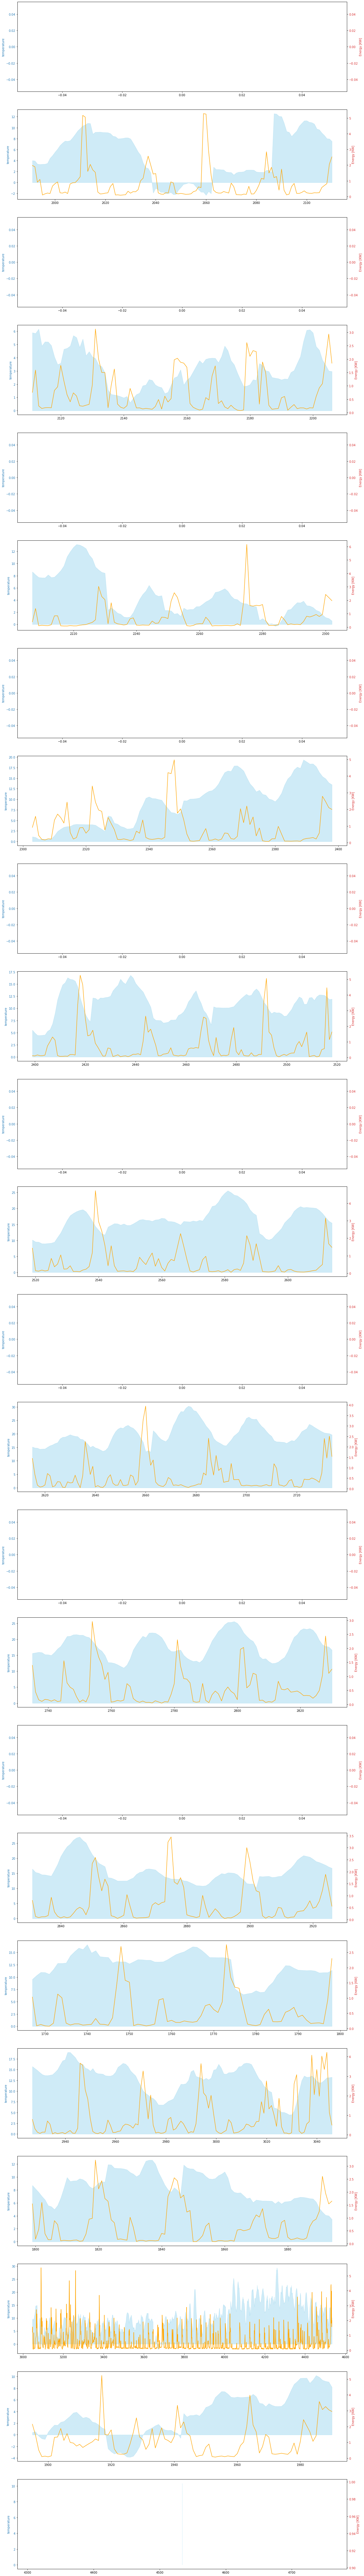

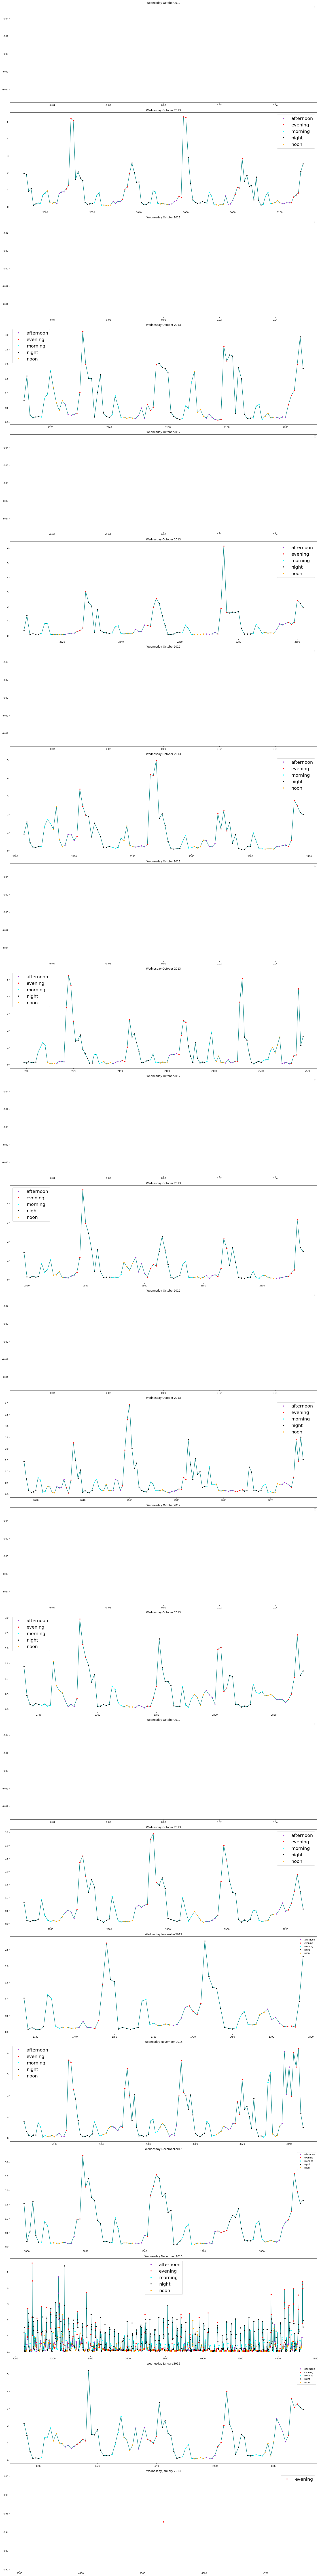

In [140]:
# plot consumption over different months for one household
ind1 = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=1,year=2012), side='left')
ind2 = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=1,year=2013), side='left')
# colors
color_dict = {
  "weekday": "blue",
  "weekend": "red",
  "holiday": "green"
}
color_dict_dp = {
  "morning": "cyan",
  "noon": "orange",
  "afternoon":"darkorchid",
  "evening": "red",
  "night":"black"
}
fig, axs = plt.subplots(24, 1, figsize=(20,20*8))
fff, xxx = plt.subplots(24, 1, figsize=(20,20*8))

for i in np.arange(1,13):
    if not i==12:
        ind1_next = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=i+1,year=2012), side='left')
    else:
        ind1_next = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=1,year=2013), side='left')
    df_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].iloc[np.arange(ind1,ind1_next),:]
    # temperature
    ax1 = axs[2*(i-1)]
    color = 'tab:blue'
    ax1.set_ylabel('temperature', color=color) 
    ax1.fill_between(df_temp[df_temp['LCLid'] == 'MAC000246'].index, np.array(df_temp[df_temp['LCLid'] == 'MAC000246'].temperature.values, dtype=float),
                 color="skyblue", alpha=0.4)
    ax1.tick_params(axis='y', labelcolor=color)
    # energy
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_xlabel('Sample Number')
    ax2.set_ylabel('Energy [KW]', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='orange')
    ind1 = ind1_next
    # energy color by time
    xxx[2*(i-1)].plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='teal')
    groups = df_temp[df_temp['LCLid'] == 'MAC000246'].groupby('daypart')
    for name, group in groups:
        xxx[2*(i-1)].plot(group.index, group.energy, marker='o', linestyle='', ms=4, label=name, c=color_dict_dp[name])
    xxx[2*(i-1)].legend()
    xxx[2*(i-1)].set_title('Wednesday' + ' '+ weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.iloc[ind1].strftime("%B") + '2012')
    
    
    
    # 2013
    if not i==12:
        ind2_next = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=i+1,year=2013), side='left')
        df_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].iloc[ind2:ind2_next,:]
    else:   
        df_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].iloc[ind2:,:]
    # temperature
    ax1 = axs[2*i-1]
    color = 'tab:blue'
    ax1.set_ylabel('temperature', color=color)  
    ax1.fill_between(df_temp[df_temp['LCLid'] == 'MAC000246'].index, np.array(df_temp[df_temp['LCLid'] == 'MAC000246'].temperature.values, dtype=float),
                 color="skyblue", alpha=0.4)
    ax1.tick_params(axis='y', labelcolor=color)
    # energy
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_xlabel('Sample Number')
    ax2.set_ylabel('Energy [KW]', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    # connect all with narrow line
    ax2.plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='orange')
    ind2 = ind2_next
    # energy color by time
    xxx[2*i-1].plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='teal')
    groups = df_temp[df_temp['LCLid'] == 'MAC000246'].groupby('daypart')
    for name, group in groups:
        xxx[2*i-1].plot(group.index, group.energy, marker='o', linestyle='', ms=4, label=name, c=color_dict_dp[name])
    xxx[2*i-1].legend(fontsize=20)
    xxx[2*i-1].set_title('Wednesday' +' ' + weather_energy_info.date.iloc[ind1].strftime("%B") + ' '+'2013')
    
plt.tight_layout()
plt.show()

## Box plots

Text(0.5, 1.0, 'Day Parts Box Plot')

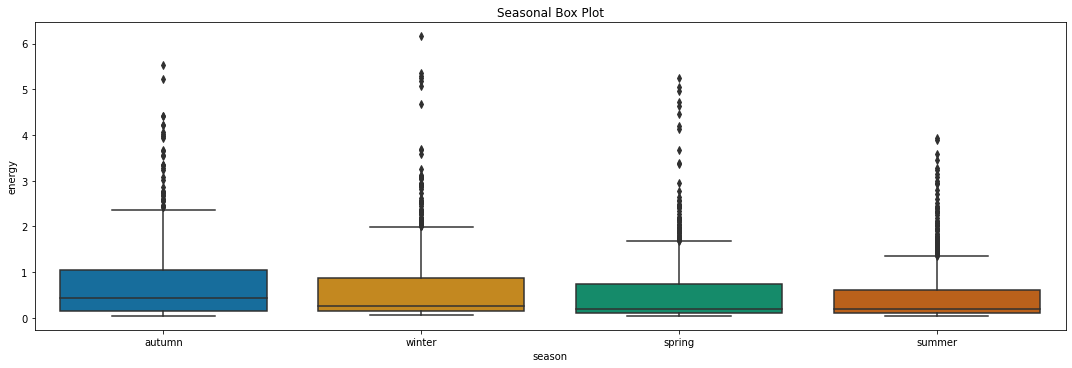

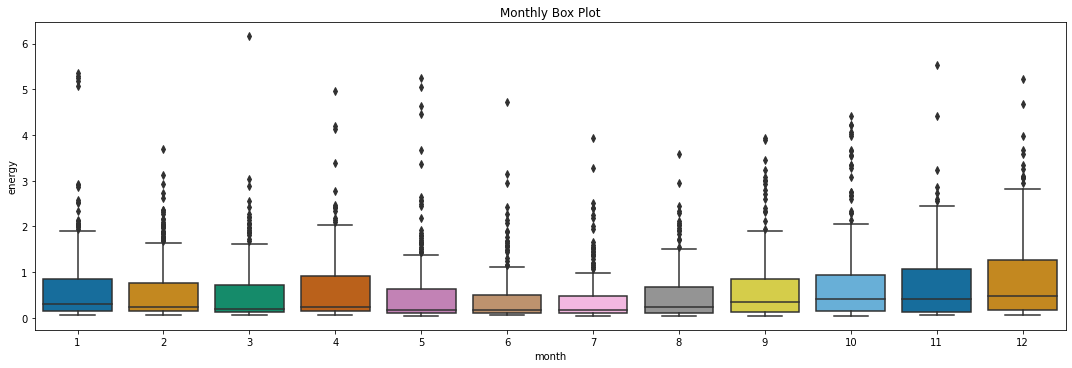

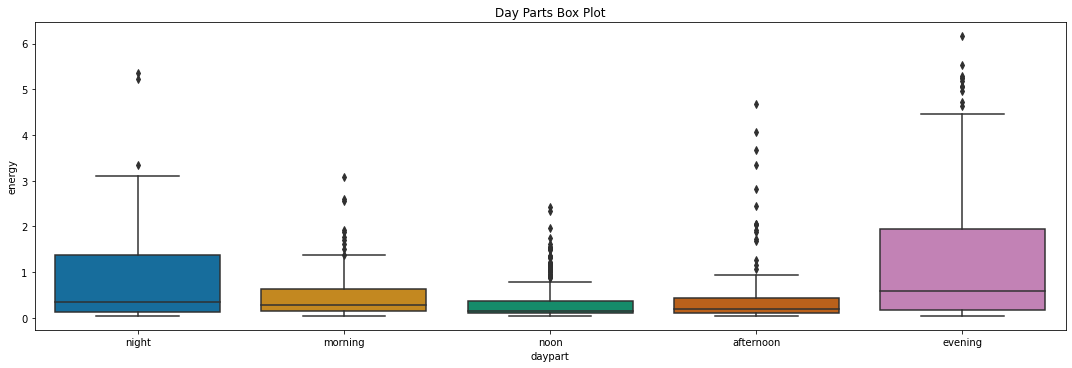

In [142]:
# Energy boxplots for one household

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='season', data=weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Seasonal Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='month', data=weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Monthly Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='daypart', data=weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Day Parts Box Plot')



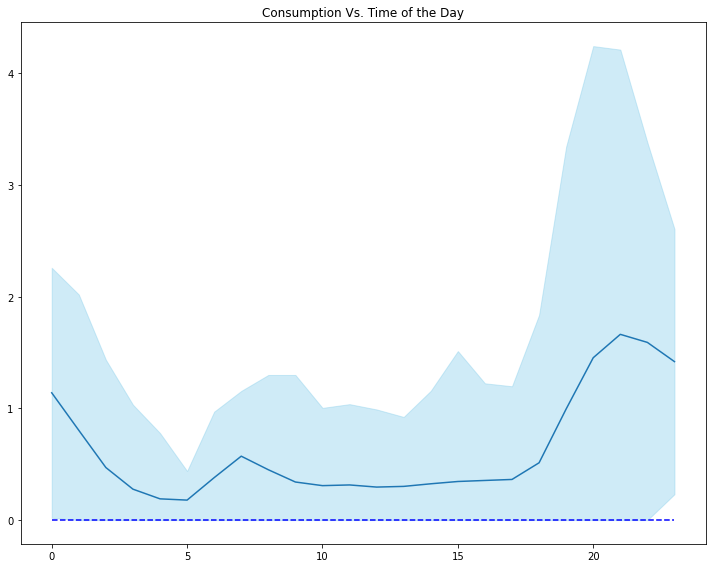

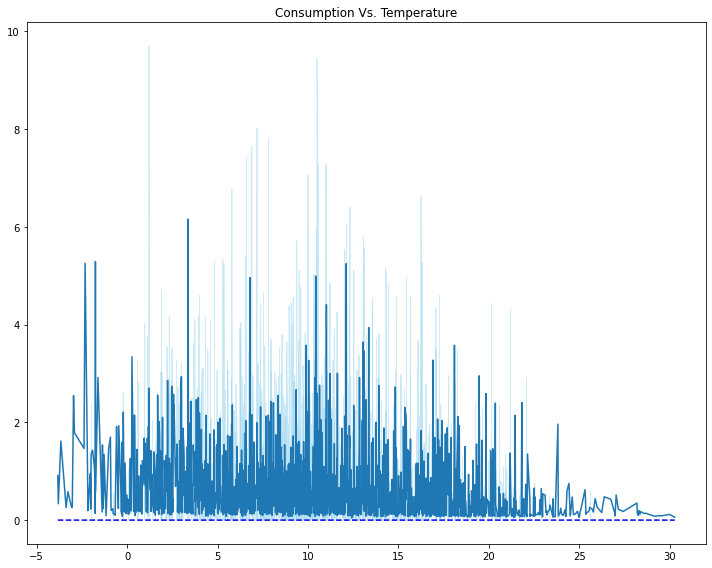

In [143]:
# dependencies of a household on different factors
fig, ax = plt.subplots(1,1,figsize=(10,8))
hours = np.arange(0,24,1)
horiz_line_data = np.zeros(24)

de_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].copy()
means = de_temp.groupby('hour', as_index=False)['energy'].mean()
means = np.array(means.energy.values, dtype=float)
stds = de_temp.groupby('hour', as_index=False)['energy'].std()
stds = np.array(stds.energy.values, dtype=float)
# plot mean
ax.plot(hours, means)
# cnof bound
ax.fill_between(hours, means+1.96*stds, np.maximum(0,means-1.96*stds),
                 color="skyblue", alpha=0.4)
ax.plot(hours, horiz_line_data, 'b--') 
ax.set_title('Consumption Vs. Time of the Day')
ax1.set_ylabel('Energy [KW]')  
plt.tight_layout()

# temperature
fig, ax = plt.subplots(1,1,figsize=(10,8))
de_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].copy()
means = de_temp.groupby('temperature', as_index=False)['energy'].mean()
temps = means.temperature.unique()
temps.sort()
horiz_line_data = np.zeros(len(temps))
means = np.array(means.energy.values, dtype=float)
stds = de_temp.groupby('temperature', as_index=False)['energy'].std()
stds = np.array(stds.energy.values, dtype=float)

# plot mean
ax.plot(temps, means)
# cnof bound
ax.fill_between(temps, means+1.96*stds, np.maximum(0,means-1.96*stds),
                 color="skyblue", alpha=0.4)
ax.plot(temps, horiz_line_data, 'b--') 
ax.set_title('Consumption Vs. Temperature')
ax1.set_ylabel('Energy [KW]')  
plt.tight_layout()

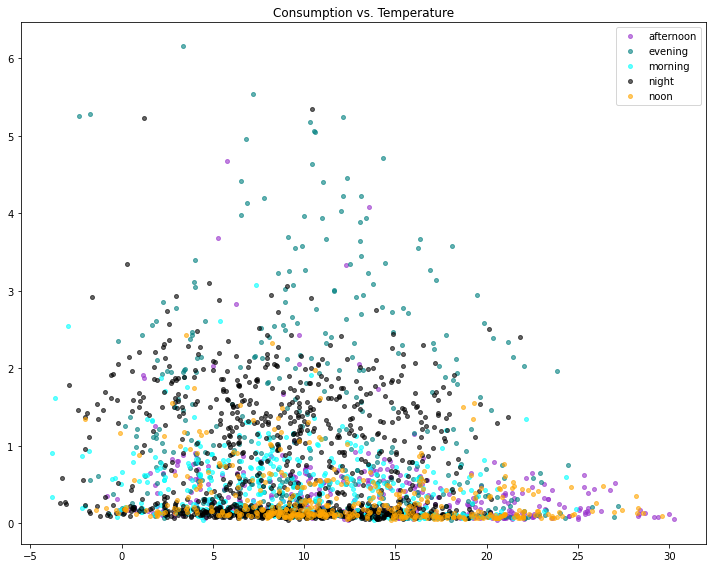

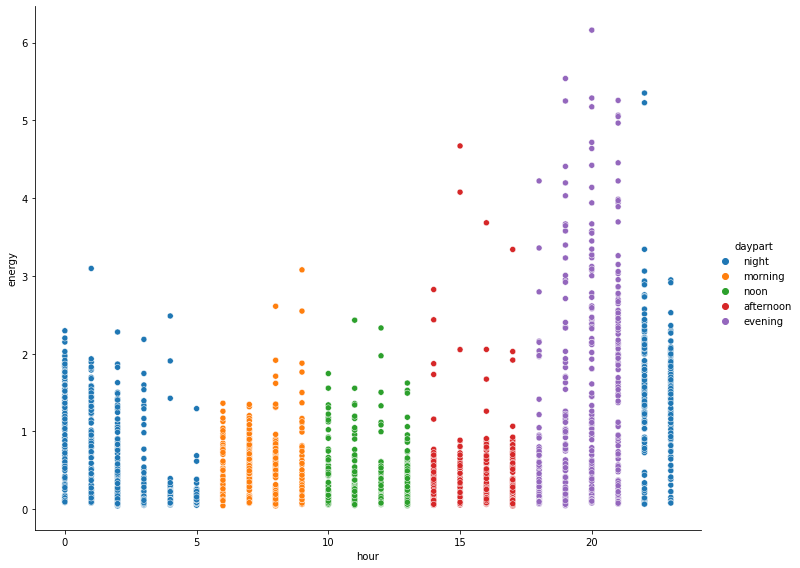

In [144]:
color_dict_dp = {
  "morning": "cyan",
  "noon": "orange",
  "afternoon":"darkorchid",
  "evening": "teal",
  "night":"black"
}
groups = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].groupby('daypart')
fig, ax = plt.subplots(figsize=(10,8))
for name, group in groups:
    ax.plot(group.temperature, group.energy, marker='o', 
            linestyle='', ms=4, label=name, c=color_dict_dp[name],alpha=0.6)
    ax.legend()
    ax.set_title('Consumption vs. Temperature')
               
plt.tight_layout()
plt.show()



pp = sns.pairplot(weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'][['energy', 'hour','daypart']],
                  x_vars=['hour'], y_vars=['energy'],
                  height=8, aspect=1.25, hue = "daypart")

#fig = pp.fig() 

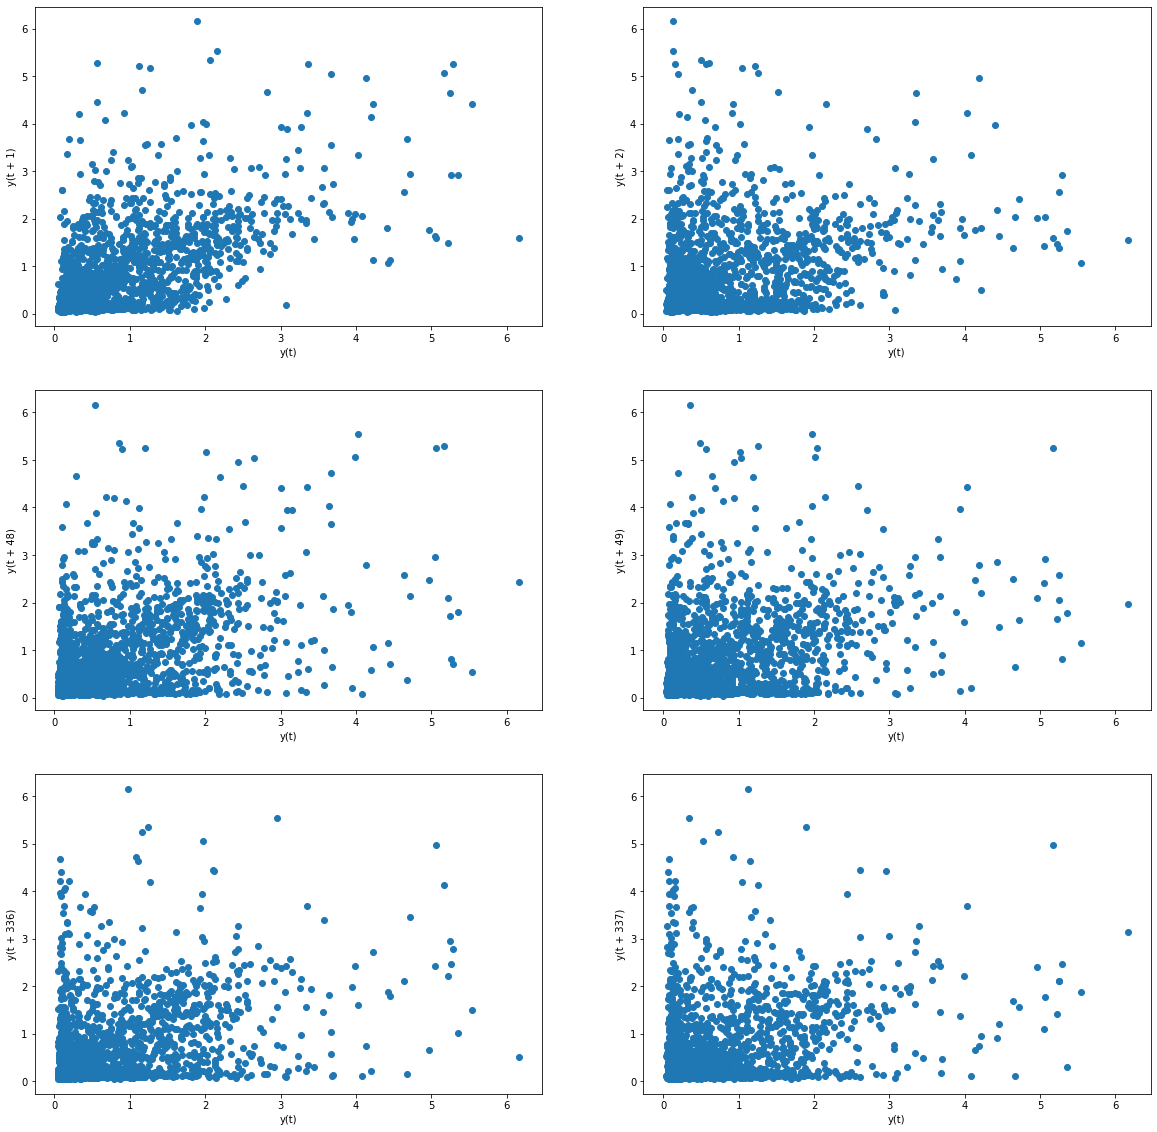

In [149]:
#lag plots for a specific household
lags = [1, 2, 48, 49, 48*7, 48*7+1]
fig, axs = plt.subplots(math.ceil(len(lags)/2), 2, figsize=(20,20))
color_dict_dp = {
  "morning": "cyan",
  "noon": "orange",
  "afternoon":"darkorchid",
  "evening": "teal",
  "night":"black"
}
for i, lag in enumerate(lags):
    #colors = [color_dict_dp[j] for j in df_1p.daypart.iloc[0:35089-lag]]
    pd.plotting.lag_plot(weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].energy, lag=lag, ax=axs[int(i/2), int(i%2)])
    


# Cutting Outliers

In [150]:
def cut_outlier(df, target):
    df_temp = df.copy()
    target_temp = target.copy()
    df_temp['energy'] = target_temp
    df_temp['datetimes'] = df.index
    filter = pd.Series([])
    for i in range(24):
        Q1 = df_temp[df_temp['hour'] == i]['energy'].quantile(0.25)
        Q3 = df_temp[df_temp['hour'] == i]['energy'].quantile(0.75)
        IQR = Q3 - Q1    #IQR is interquartile range. 
        filter = filter.append((df_temp[df_temp['hour'] == i]['energy'] >= Q1 - 1.5 * IQR) & (df_temp[df_temp['hour'] == i]['energy'] <= Q3 + 1.5 *IQR))
    filter.sort_index(ascending=True, inplace = True)
    df_temp = df_temp.loc[filter]
    df_temp.reset_index(inplace = True)
    df_temp.set_index(['datetimes'],inplace=True)
    target_temp = df_temp['energy']
    df_temp.drop(columns = 'energy', inplace = True)
    df_temp.drop(columns = ['datetime'], inplace = True)
    return df_temp, target_temp

# Automated Feature selection

In [151]:
# putting time in a sinusoidal function (solely for feature selection purposes)
weather_energy_info['hourofd_x'] = np.sin(weather_energy_info['time']/24*2*math.pi)
weather_energy_info['hourofd_y'] = np.cos(weather_energy_info['time']/24*2*math.pi)

In [163]:
# fitting KBest algorithm to get an indication of most important features
features = list(set(list(weather_energy_info.columns)) - set(['energy', 'daypart', 'season', 'weekday', 'stdorToU', 'tstp', 'Acorn','Acorn_grouped', 'datetime','date', 'Bank holidays', 'Type', 'LCLid', 'hour', 'apparentTemperature']))
X = weather_energy_info.loc[:, features]
Y = weather_energy_info['energy']
KBest = SelectKBest(score_func = f_regression, k = 24) #f_regression criterion selected
KBest = KBest.fit(X,Y)
df_scores = pd.DataFrame({'features': X.columns, 'Mutual_info': KBest.scores_, 'pValue': KBest.pvalues_ })
df_scores

C:\Users\denis\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


features    Mutual_info         pValue
0       pressure     111.157838   5.669945e-26
1   day_of_month       0.576296   4.477700e-01
2    holiday_ind      49.182707   2.349290e-12
3       dayofy_y     629.402301  2.157121e-138
4            ld1  120378.124277   0.000000e+00
5      hourofd_y      47.324949   6.055580e-12
6          lag24  115227.765245   0.000000e+00
7           lag5   42850.579584   0.000000e+00
8         dayofy       9.034129   2.650625e-03
9    temperature     256.723982   1.079655e-57
10      humidity       8.721532   3.145597e-03
11  flag_weekend            NaN            NaN
12     hourofd_x    3217.412095   0.000000e+00
13      dewPoint     348.806416   1.103853e-77
14    visibility      19.384727   1.069884e-05
15     time_conv    4398.393473   0.000000e+00
16      dayofy_x       0.003947   9.499050e-01
17   windBearing       7.217754   7.220001e-03
18          lag1  245459.566461   0.000000e+00
19          lag2  113678.200065   0.000000e+00
20         lag26   67975.239331   0.000000e+00
21          time    4398.393473   0.000000e+00
22        minute            NaN            NaN
23     windSpeed     288.811323   1.155008e-64
24         index     712.688922  2.308654e-156
25         lag25   93505.733497   0.000000e+00
26         month       8.456055   3.639241e-03
27           ld0  156922.265295   0.000000e+00
28          lag3   75035.041667   0.000000e+00
29          lag4   54653.104633   0.000000e+00
30           ld3   63903.666787   0.000000e+00
31           ld2   85148.168510   0.000000e+00

In [164]:
# get column indexes
cols = KBest.get_support(indices=True)
cols

array([ 0,  2,  3,  4,  5,  6,  7,  9, 12, 13, 14, 15, 18, 19, 20, 21, 23,
       24, 25, 27, 28, 29, 30, 31], dtype=int64)

In [165]:
# get column names
features = X.columns[cols]
features

Index(['pressure', 'holiday_ind', 'dayofy_y', 'ld1', 'hourofd_y', 'lag24',
       'lag5', 'temperature', 'hourofd_x', 'dewPoint', 'visibility',
       'time_conv', 'lag1', 'lag2', 'lag26', 'time', 'windSpeed', 'index',
       'lag25', 'ld0', 'lag3', 'lag4', 'ld3', 'ld2'],
      dtype='object')

# Model construction

In [166]:
# setting datetime as index
weather_energy_info.set_index(['datetime'],inplace=True)
weather_energy_info.head()

In [853]:
# saving preprocessed dataframe to pickle
weather_energy_info.to_pickle("data/weather_energy_info.pkl", compression='bz2')

In [851]:
# loading preprocessed dataframes from pickle and initializing needed variables
weather_energy_info = pd.read_pickle("data/weather_energy_info.pkl",compression='bz2')
weather_energy = pd.read_pickle("data/weather_energy.pkl",compression='bz2')
uniqueValues = weather_energy_info['LCLid'].unique()

In [168]:
# splitting main dataframe into a list of dataframes based on house id
ds = []
for i in uniqueValues:
    ds.append(weather_energy_info[weather_energy_info['LCLid']== i])

In [171]:
# splitting into x and y, with needed features for x
model_data_x = []
model_data_y = []
for i in range(len(ds)):
    model_data_x.append(ds[i][['hour','minute','temperature','humidity','holiday_ind', 'month', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag24', 'lag25', 'lag26','ld0', 'ld1', 'ld2', 'ld3', 'dayofy_x', 'dayofy_y', 'daypart']])
    model_data_y.append(ds[i][['energy']])

In [172]:
# setting a fraction for train/test split
fraction = 0.75

In [173]:
# train/test split (needs to be done manually to conserve time series continuity)
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(ds)):
    X_train.append(model_data_x[i][26:int(fraction*len(model_data_x[i]))])
    y_train.append(model_data_y[i][26:int(fraction*len(model_data_y[i]))])
    X_test.append(model_data_x[i][int(fraction*len(model_data_x[i])):])
    y_test.append(model_data_y[i][int(fraction*len(model_data_x[i])):])

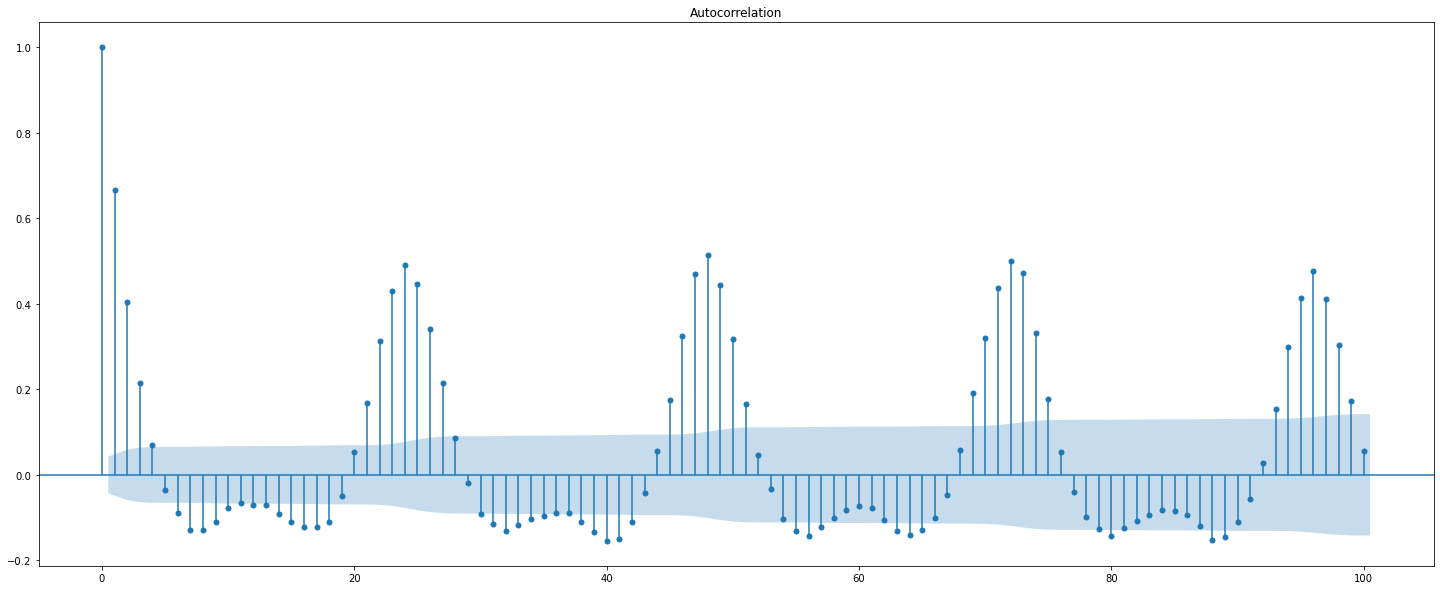

In [184]:
# autocorrelation plot
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(y_train[1].energy,lags=100, ax = ax)
plt.show()

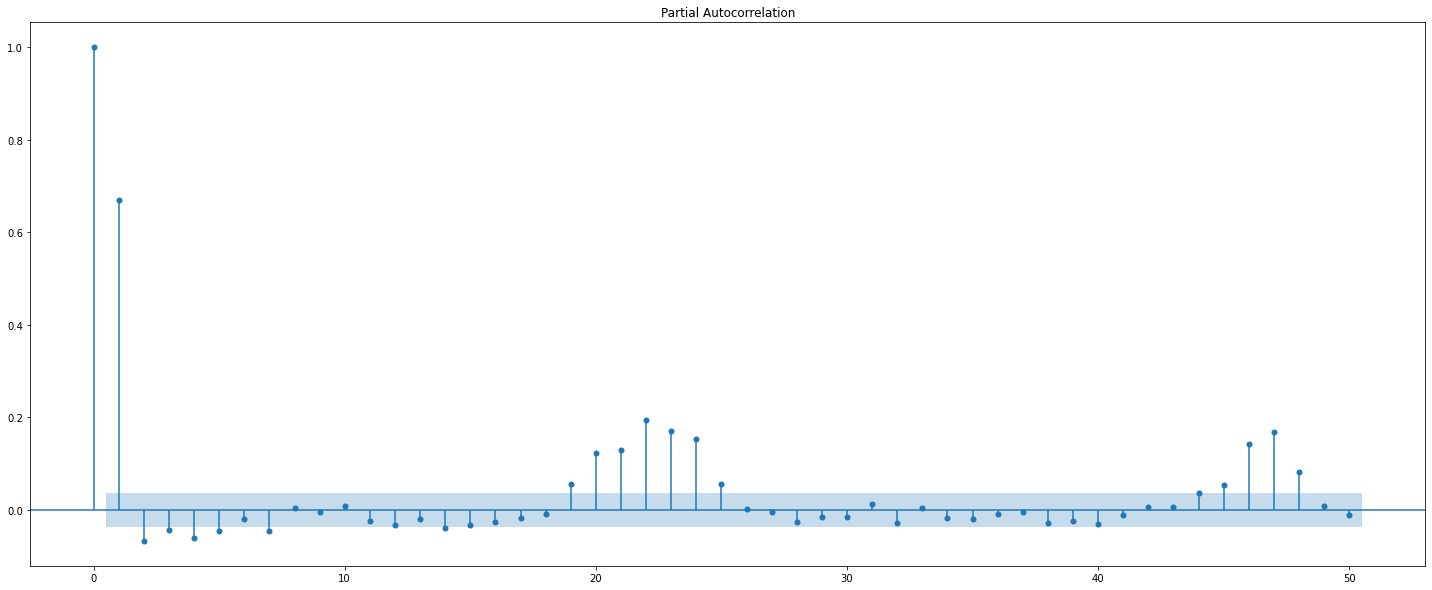

In [187]:
# partial autocorrelation plot
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(model_data_y[1].energy,lags=50, ax = ax)
plt.show()

In [191]:
#Dickey Fuller Test (stationarity test)
t = sm.tsa.adfuller(model_data_y[1].energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -4.969156
p-value                           0.000026
#Lags Used                       24.000000
Number of Observations Used    2783.000000
dtype: float64

In [189]:
# changing DateTimeIndex to period of 1 hour
for i in range(len(ds)):    
    X_train[i].index = pd.DatetimeIndex(X_train[i].index).to_period('60T')
    X_test[i].index = pd.DatetimeIndex(X_test[i].index).to_period('60T')
    y_train[i].index = pd.DatetimeIndex(y_train[i].index).to_period('60T')
    y_test[i].index = pd.DatetimeIndex(y_test[i].index).to_period('60T')

In [190]:
# converting time into a float representation of time (5:30->5.5)
for i in range(len(ds)):   
    X_train[i]['time'] = X_train[i]['hour'] + X_train[i]['minute']/60
    X_test[i]['time'] = X_test[i]['hour'] + X_test[i]['minute']/60

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1611360047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['time'] = X_train[i]['hour'] + X_train[i]['minute']/60
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1611360047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i]['time'] = X_test[i]['hour'] + X_test[i]['minute']/60


In [192]:
# putting time in a sinusoidal function 
for i in range(len(ds)):   
    X_train[i]['hourofd_x'] = np.sin(X_train[i]['time']/24*2*math.pi)
    X_train[i]['hourofd_y'] = np.cos(X_train[i]['time']/24*2*math.pi)
    X_test[i]['hourofd_x'] = np.sin(X_test[i]['time']/24*2*math.pi)
    X_test[i]['hourofd_y'] = np.cos(X_test[i]['time']/24*2*math.pi)

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/2028261343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['hourofd_x'] = np.sin(X_train[i]['time']/24*2*math.pi)
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/2028261343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['hourofd_y'] = np.cos(X_train[i]['time']/24*2*math.pi)
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/2028261343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [193]:
# Label Encoding dayparts
le = preprocessing.LabelEncoder()
for i in range(len(ds)): 
    X_train[i]['daypart'] = le.fit_transform(X_train[i]['daypart'])
    X_test[i]['daypart'] = le.fit_transform(X_test[i]['daypart'])

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/547299480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['daypart'] = le.fit_transform(X_train[i]['daypart'])
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/547299480.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i]['daypart'] = le.fit_transform(X_test[i]['daypart'])


In [194]:
# Cutting outliers only in train data(create new dataframe for experimentation)
X_train_no_out = []
y_train_no_out = []
for i in range(len(ds)): 
    out_x, out_y = cut_outlier(X_train[i], y_train[i])
    X_train_no_out.append(out_x)
    y_train_no_out.append(out_y)

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3300090591.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filter = pd.Series([])


In [195]:
# Cutting outliers in all data
model_no_out = []
output_test_no_out = []
for i in range(len(ds)): 
    x_out, y_out = cut_outlier(model_data_x[i][26:], model_data_y[i][26:])
    model_no_out.append(x_out)
    output_test_no_out.append(y_out)

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3300090591.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filter = pd.Series([])


In [196]:
# splitting into train/test sets of the model with no outliers and preprocessing
X_train_filt = []
y_train_filt = []
X_test_filt = []
y_test_filt = []
for i in range(len(ds)): 
    X_train_filt.append(model_no_out[i][:int(fraction*len(model_no_out[i]))])
    y_train_filt.append(output_test_no_out[i][:int(fraction*len(output_test_no_out[i]))])
    X_test_filt.append(model_no_out[i][int(fraction*len(model_no_out[i])):])
    y_test_filt.append(output_test_no_out[i][int(fraction*len(output_test_no_out[i])):])
for i in range(len(ds)): 
    X_train_filt[i].index = pd.DatetimeIndex(X_train_filt[i].index).to_period('60T')
    X_test_filt[i].index = pd.DatetimeIndex(X_test_filt[i].index).to_period('60T')
    y_train_filt[i].index = pd.DatetimeIndex(y_train_filt[i].index).to_period('60T')
    y_test_filt[i].index = pd.DatetimeIndex(y_test_filt[i].index).to_period('60T')

    X_train_filt[i]['time'] = X_train_filt[i]['hour'] + X_train_filt[i]['minute']/60
    X_test_filt[i]['time'] = X_test_filt[i]['hour'] + X_test_filt[i]['minute']/60

    X_train_filt[i]['hourofd_x'] = np.sin(X_train_filt[i]['time']/24*2*math.pi)
    X_train_filt[i]['hourofd_y'] = np.cos(X_train_filt[i]['time']/24*2*math.pi)

    X_test_filt[i]['hourofd_x'] = np.sin(X_test_filt[i]['time']/24*2*math.pi)
    X_test_filt[i]['hourofd_y'] = np.cos(X_test_filt[i]['time']/24*2*math.pi)

    X_train_filt[i]['daypart'] = le.fit_transform(X_train_filt[i]['daypart'])
    X_test_filt[i]['daypart'] = le.fit_transform(X_test_filt[i]['daypart'])

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1196428038.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_filt[i]['time'] = X_train_filt[i]['hour'] + X_train_filt[i]['minute']/60
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1196428038.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_filt[i]['time'] = X_test_filt[i]['hour'] + X_test_filt[i]['minute']/60
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1196428038.py:20: SettingWithCopyWarning: 
A value is trying to be set on a

In [197]:
# scaling of the data
sc = StandardScaler()
X_train_sc = []
X_test_sc = []
# following loops are needed due to data types returned by standard scaler
for i in range(len(ds)): 
    X_train_sc.append(sc.fit_transform(X_train[i]))
    X_test_sc.append(sc.fit_transform(X_test[i]))
for i in range(len(ds)): 
    X_train[i] = pd.DataFrame(X_train_sc[i], index=X_train[i].index, columns=X_train[i].columns)
    X_test[i] = pd.DataFrame(X_test_sc[i], index=X_test[i].index, columns=X_test[i].columns)

# Models (for single household)

## SVR 

In [256]:
# fitting SVR
svr_fit = svm.NuSVR(kernel='poly', degree = 1,C = 0.1, nu = 0.7).fit(X_train[1], y_train[1])
svrscore = svr_fit.score(X_train[1], y_train[1])
print(svrscore)

C:\Users\denis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5152141209367016


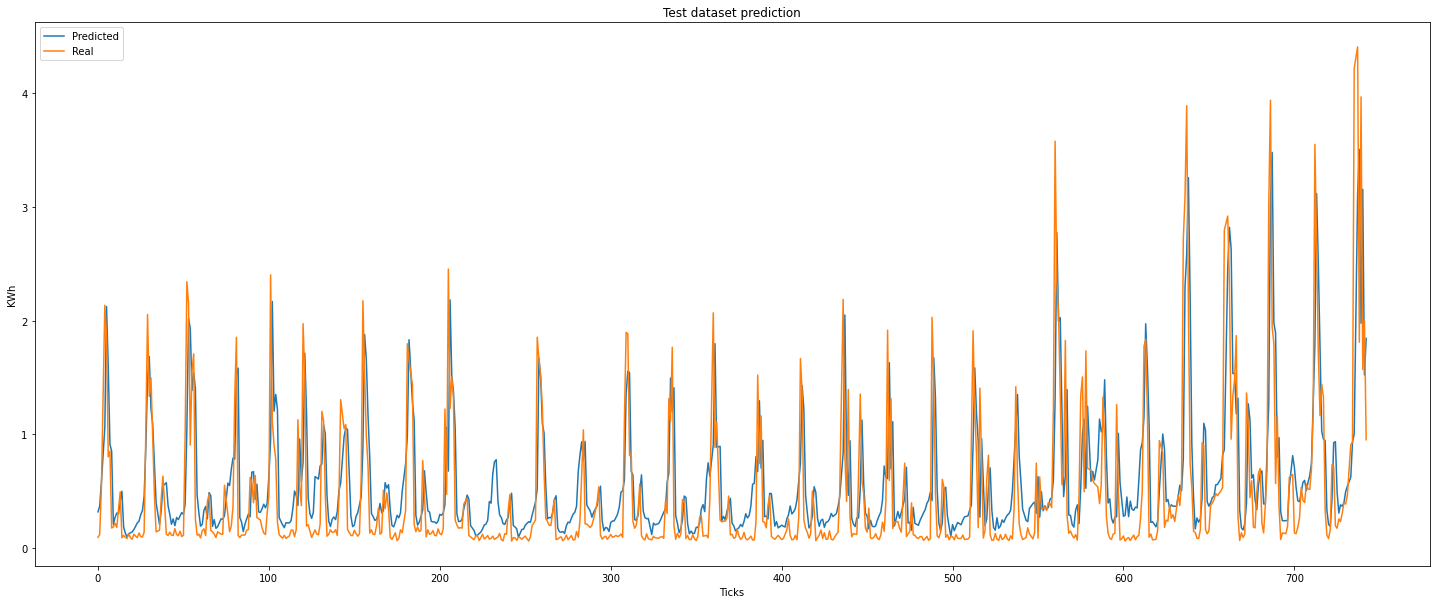

In [257]:
# fitting on test data and plotting result
plt.figure(figsize = (25,10))
predictions_svr = svr_fit.predict(X_test[1])
for i in range(len(predictions_svr)):
    if predictions_svr[i] < 0:
        predictions_svr[i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_svr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

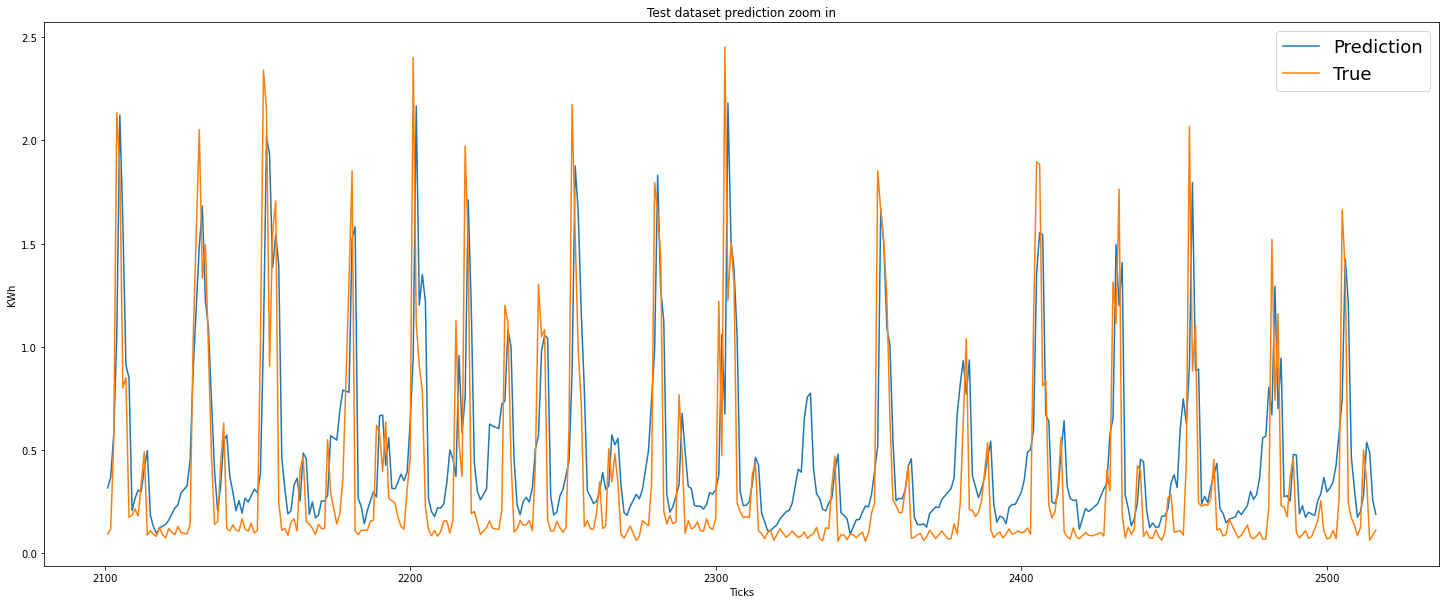

In [259]:
# plotting zoomed in version
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2000:2400], predictions_svr[:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18, loc = 0)

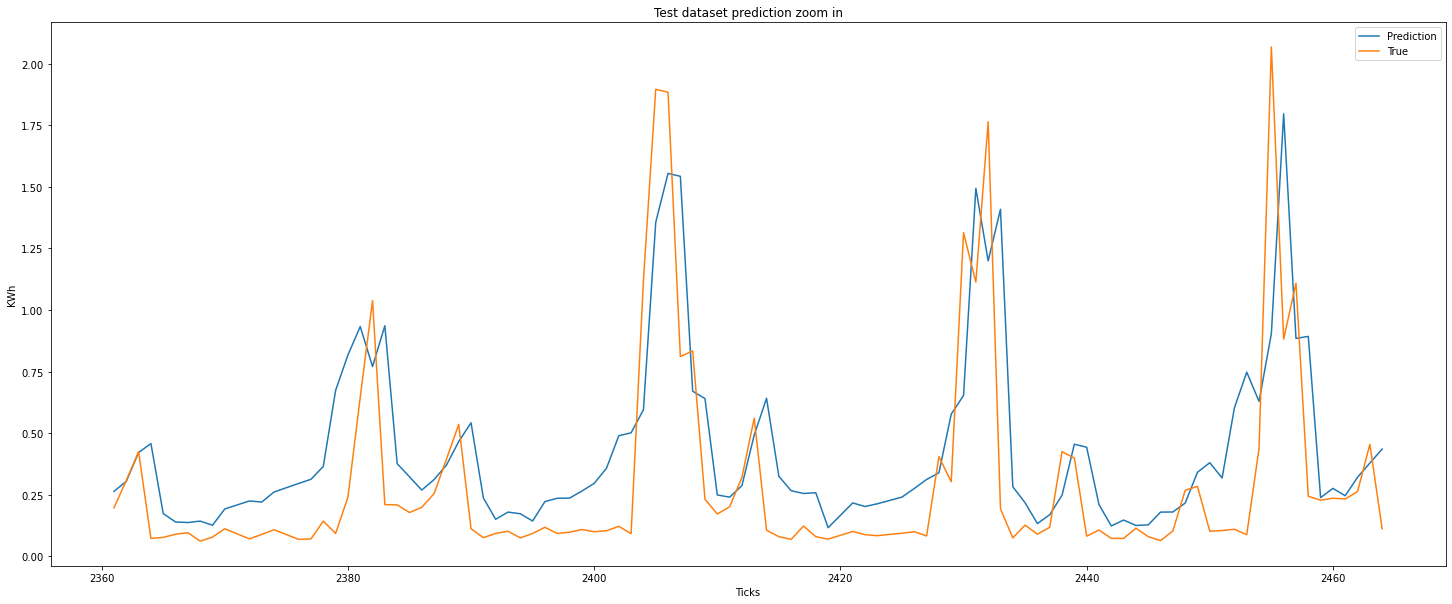

In [262]:
# zoomning even more
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2250:2350], predictions_svr[250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [263]:
# Metrics: MSE, R2, MAE, MDA
test_score_svr = mean_squared_error(y_test[1], predictions_svr)
print('Test MSE: %.3f' % test_score_svr)

Test MSE: 0.228


In [264]:
r2_score(y_test[1], predictions_svr)

0.4715748893711925

In [265]:
mda(np.asarray(y_test[1]), predictions_svr)

0.49745523513383166

In [266]:
test_score_mae = mean_absolute_error(y_test[1], predictions_svr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.310


### No outliers in train data

In [364]:
# same order of procedures as above
svr_fit = svm.NuSVR(kernel='poly', degree = 1,C = 100, nu = 0.2).fit(X_train_no_out[1], y_train_no_out[1])
svrscore = svr_fit.score(X_train_no_out[1], y_train_no_out[1])
print(svrscore)

0.5983324633222884


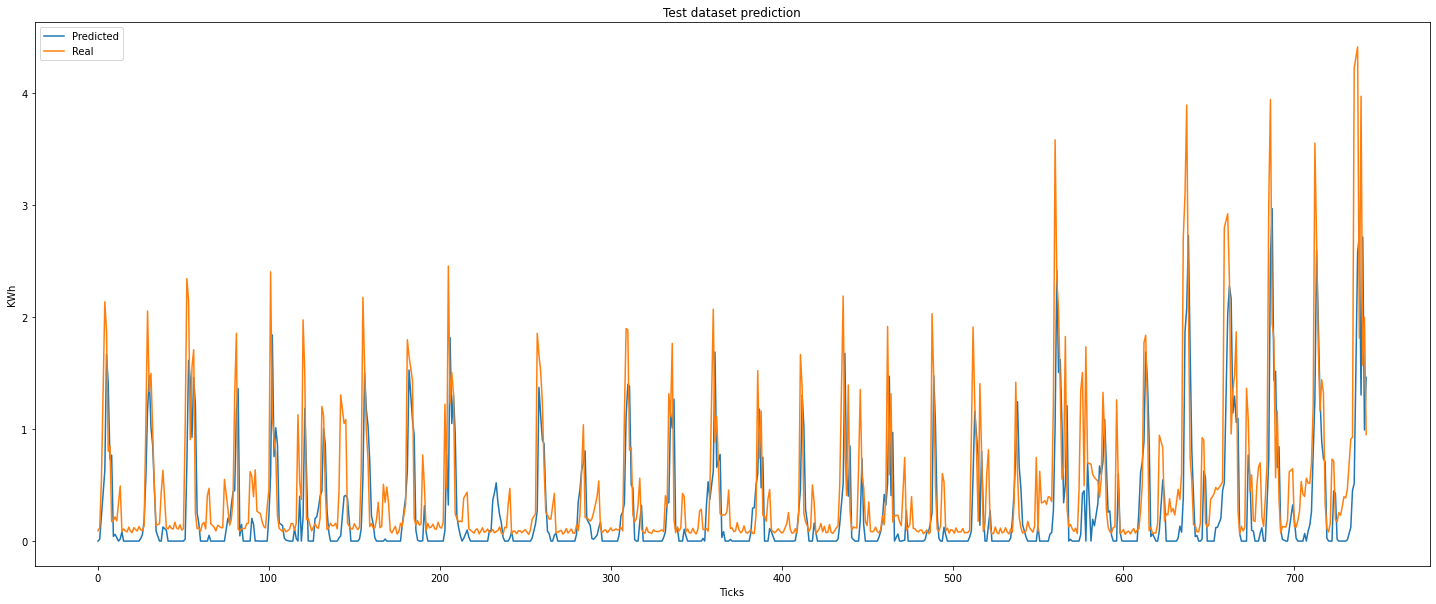

In [375]:
plt.figure(figsize = (25,10))
predictions_svr = svr_fit.predict(X_test[1])
for i in range(len(predictions_svr)):
    if predictions_svr[i] < 0:
        predictions_svr[i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_svr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [376]:
test_score_svr = mean_squared_error(y_test[1], predictions_svr)
print('Test MSE: %.3f' % test_score_svr)

Test MSE: 0.266


In [377]:
r2_score(y_test[1], predictions_svr)

0.3834285719140824

In [378]:
mda(np.asarray(y_test[1]), predictions_svr)

0.31495458902200035

In [379]:
test_score_mae = mean_absolute_error(y_test[1], predictions_svr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.313


### No outliers in all data

In [427]:
# same order of procedure as above
svr_fit = svm.NuSVR(kernel='poly', degree = 3,C = 100, nu = 0.7).fit(X_train_filt[1], y_train_filt[1])
svrscore = svr_fit.score(X_train_filt[1], y_train_filt[1])
print(svrscore)

0.7188644817924987


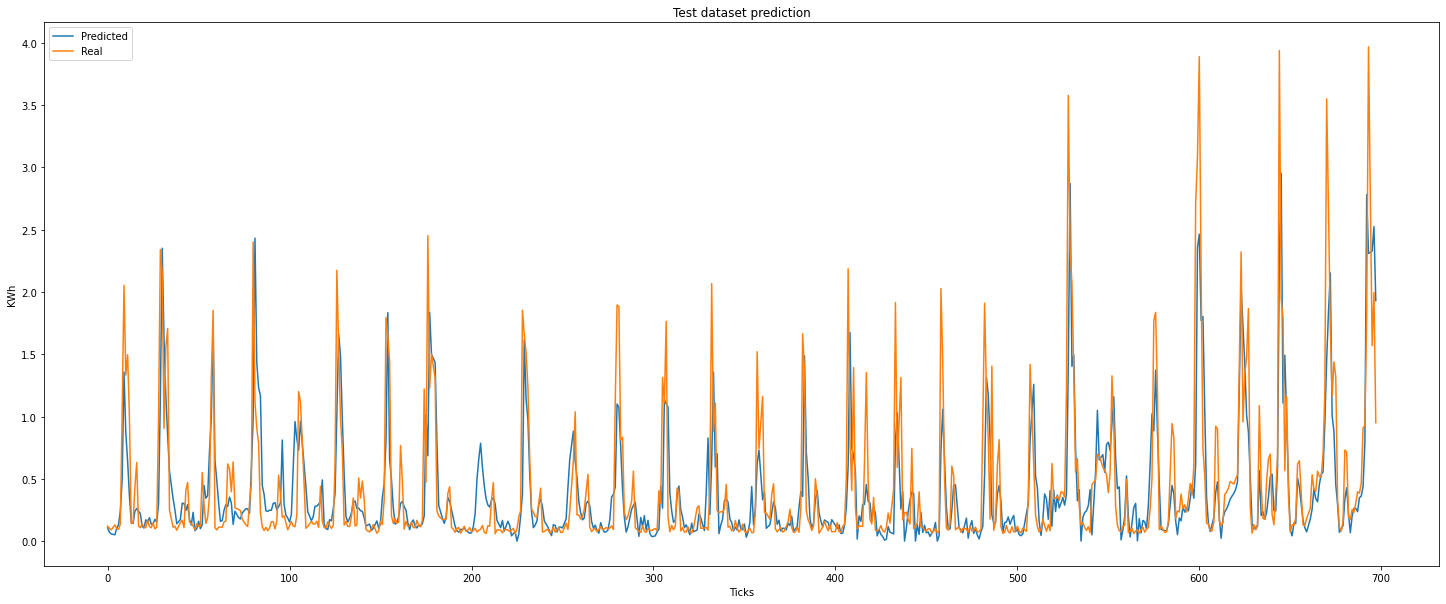

In [428]:
plt.figure(figsize = (25,10))
predictions_svr = svr_fit.predict(X_test_filt[1])
for i in range(len(predictions_svr)):
    if predictions_svr[i] < 0:
        predictions_svr[i] = 0
plt.plot(weather_energy.index[:len(predictions_svr)], predictions_svr, label = 'Predicted')
plt.plot(weather_energy.index[:len(predictions_svr)],y_test_filt[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [429]:
test_score_svr = mean_squared_error(y_test_filt[1], predictions_svr)
print('Test MSE: %.3f' % test_score_svr)

Test MSE: 0.149


In [430]:
r2_score(y_test_filt[1], predictions_svr)

0.5825165849584093

In [431]:
mda(np.asarray(y_test_filt[1]), predictions_svr)

0.582701062215478

In [432]:
test_score_mae = mean_absolute_error(y_test_filt[1], predictions_svr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.221


## GPR

In [458]:
# fitting GPR on training data
kernels_gpr = kernels.RBF(length_scale = 0.51) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = 0.2) 
gpr = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train[1], y_train[1])
gprscore = gpr.score(X_train[1], y_train[1])
print(gprscore)

0.6771541689971415


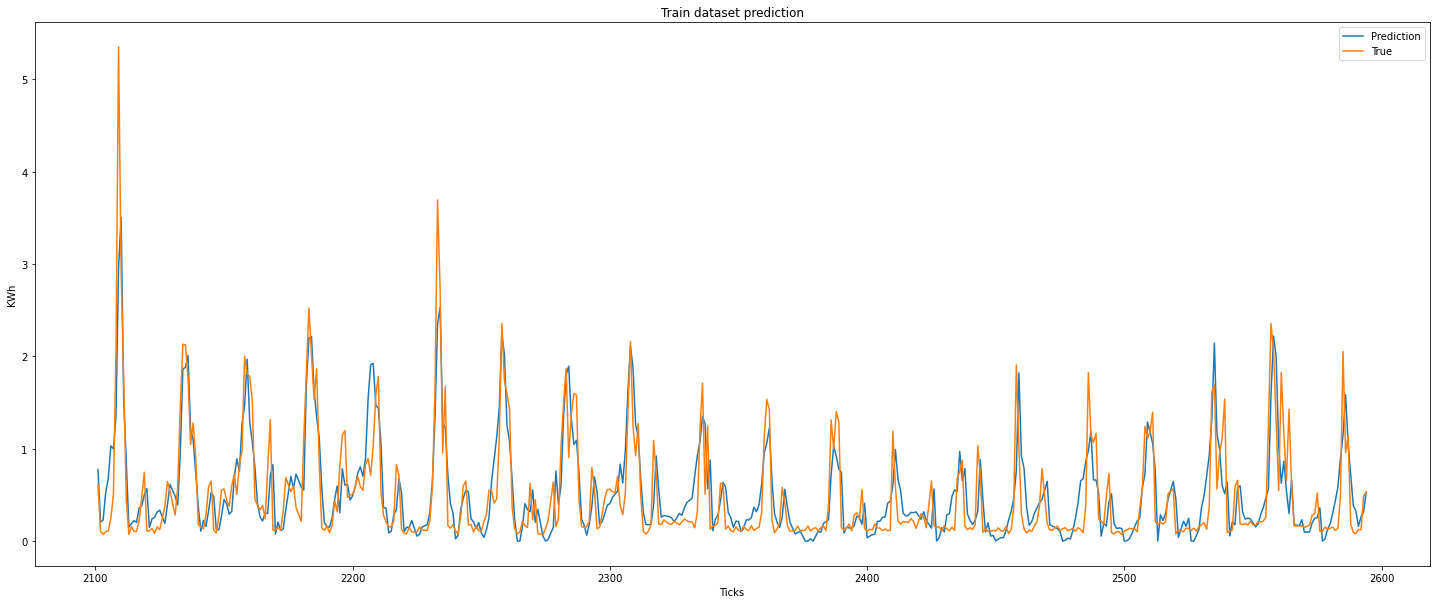

In [459]:
# plotting resulting predictions on train data
plt.figure(figsize = (25,10))
predictions_gpr_tr = gpr.predict(X_train[1], return_std = True)
for i in range(len(predictions_gpr_tr[0])):
    if predictions_gpr_tr[0][i] < 0:
        predictions_gpr_tr[0][i] = 0
plt.plot(weather_energy.index[2000:2474], predictions_gpr_tr[0][1500:1974], label = 'Prediction')
plt.plot(weather_energy.index[2000:2474],y_train[1][1500:1974], label = 'True')
#plt.fill_between(weather_energy.index[:2000], predictions_gpr_tr[0].flatten() + predictions_gpr_tr[1], predictions_gpr_tr[0].flatten() - predictions_gpr_tr[1], color='g', alpha=0.2)
plt.title('Train dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

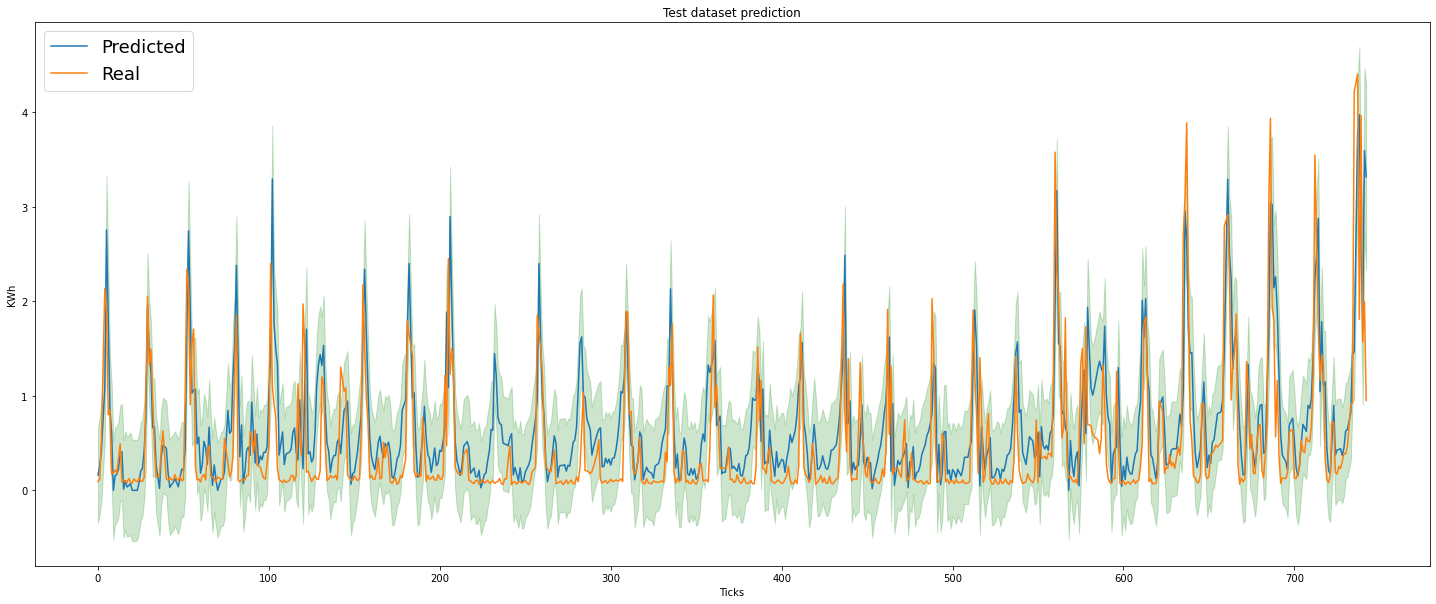

In [460]:
# fitting on test data and plotting the result
plt.figure(figsize = (25,10))
predictions_gpr = gpr.predict(X_test[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_gpr[0], label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.fill_between(weather_energy.index[:len(y_test[1])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

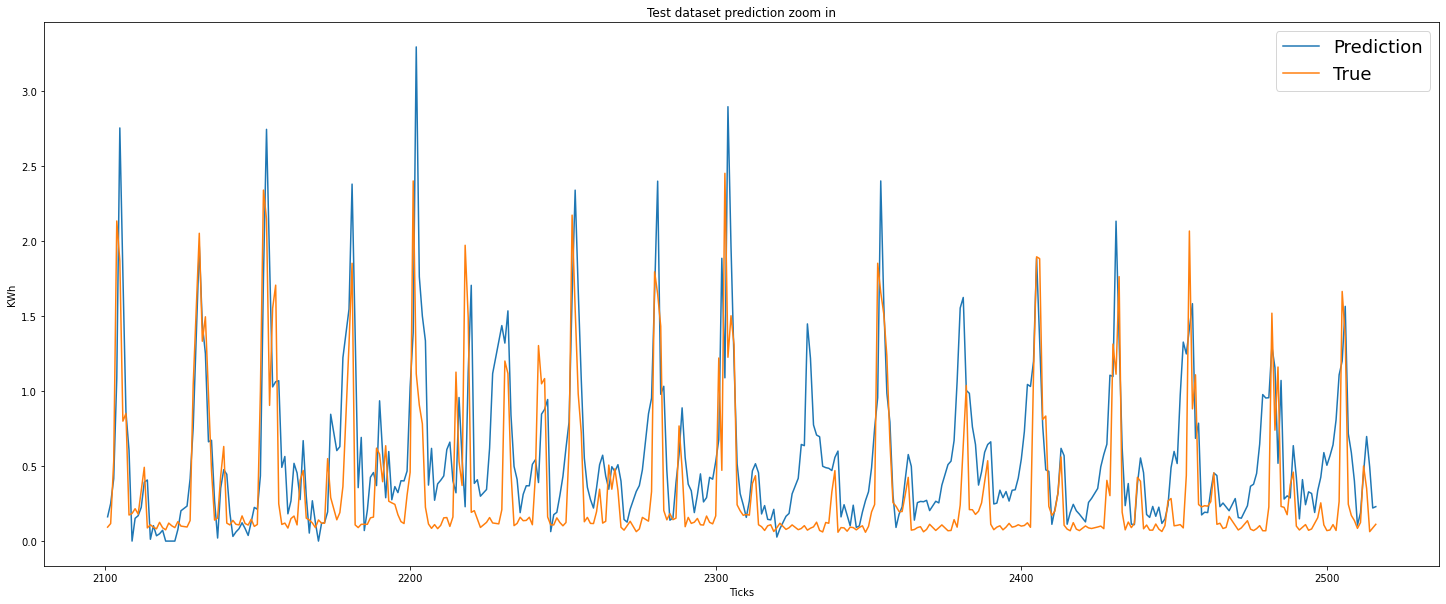

In [461]:
# zooming in
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2000:2400], predictions_gpr[0][0:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

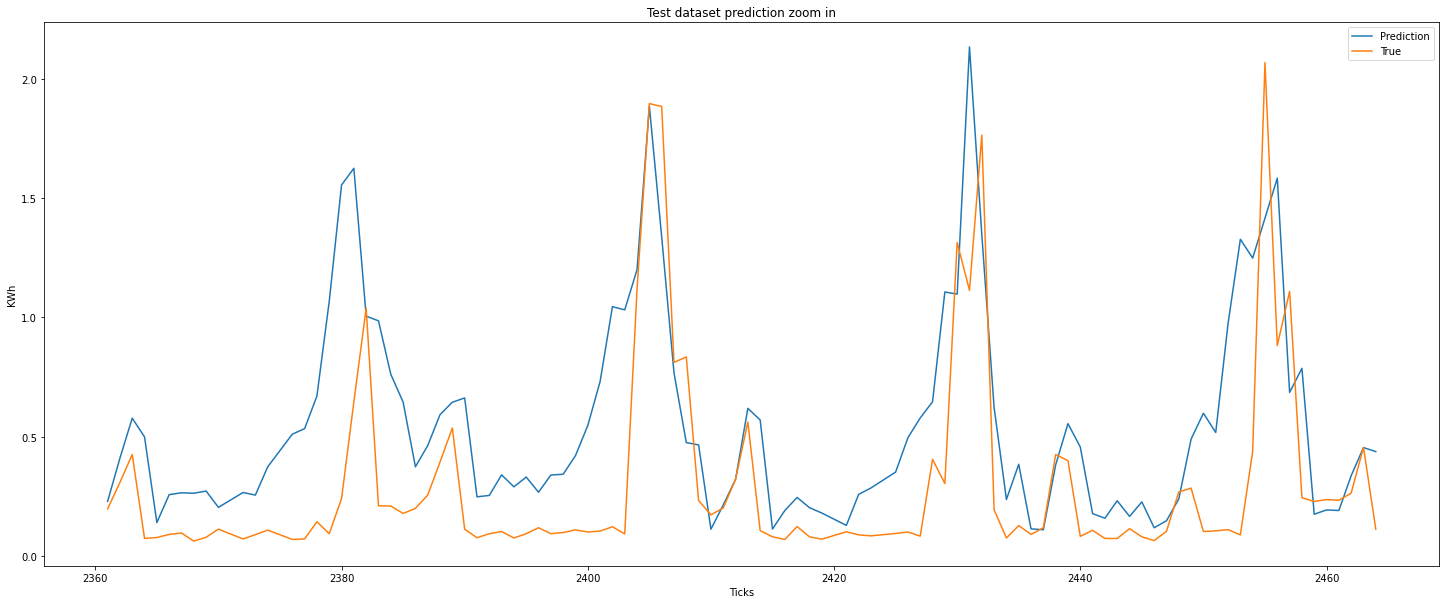

In [462]:
# zooming in
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2250:2350], predictions_gpr[0][250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [463]:
# metrics: MSE, R2, MAE, MDA
test_score = mean_squared_error(y_test[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.256


In [464]:
r2_score(y_test[1], predictions_gpr[0])

0.4064615302731237

In [465]:
mda(np.asarray(y_test[1]), predictions_gpr[0])

0.5748930099857347

In [466]:
test_score_mae = mean_absolute_error(y_test[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.353


### No outliers in train data

In [449]:
# same procedure as above
kernels_gpr = kernels.RBF(length_scale = 0.51) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = 0.2) 
gpr = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train_no_out[1], y_train_no_out[1])
gprscore = gpr.score(X_train_no_out[1], y_train_no_out[1])
print(gprscore)

0.7771016982491807


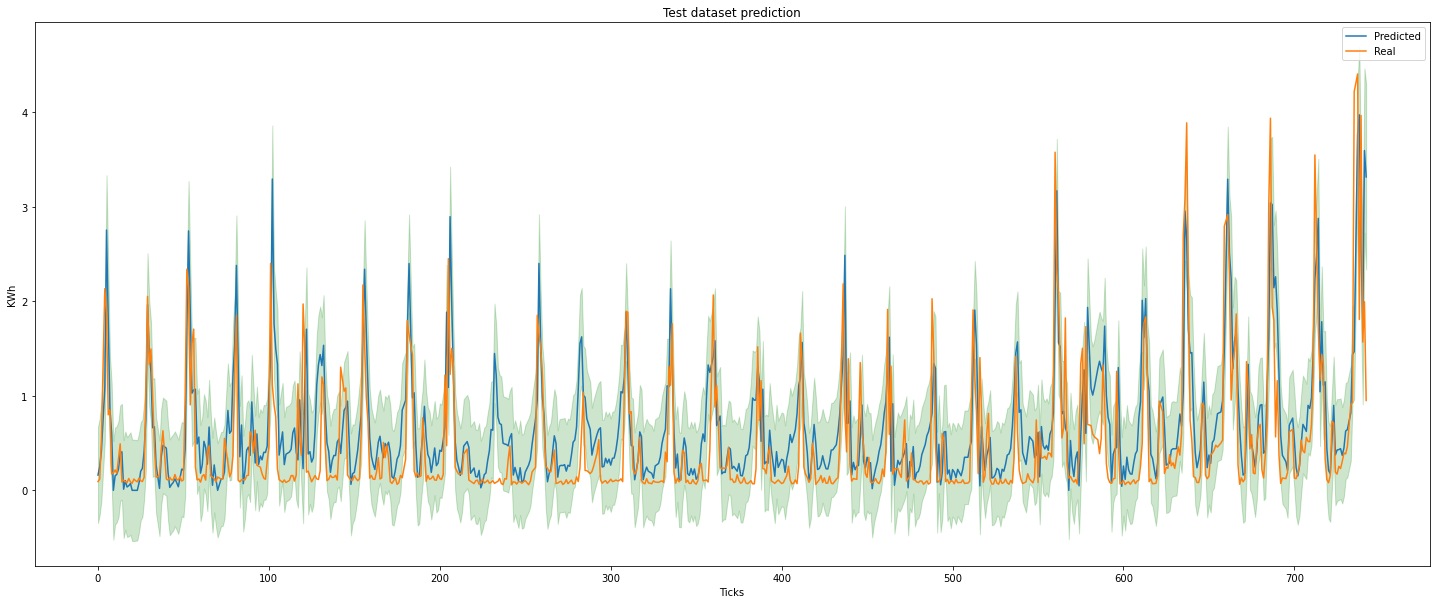

In [469]:
plt.figure(figsize = (25,10))
predictions_gpr = gpr.predict(X_test[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_gpr[0], label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.fill_between(weather_energy.index[:len(y_test[1])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [470]:
test_score = mean_squared_error(y_test[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.256


In [471]:
r2_score(y_test[1], predictions_gpr[0])

0.4064615302731237

In [472]:
mda(np.asarray(y_test[1]), predictions_gpr[0])

0.5748930099857347

In [473]:
test_score_mae = mean_absolute_error(y_test[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.353


### No outliers in all data

In [474]:
gpr = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train_filt[1], y_train_filt[1])
gprscore = gpr.score(X_train_filt[1], y_train_filt[1])
print(gprscore)

0.7837851094337933


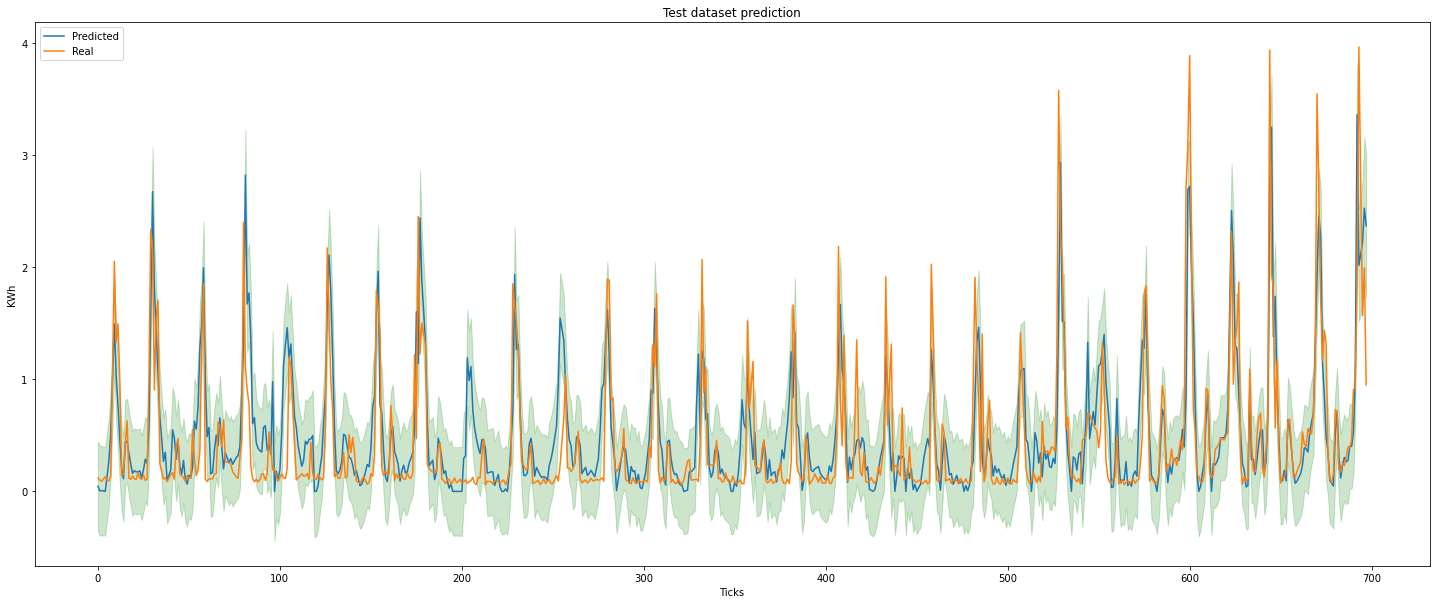

In [476]:
plt.figure(figsize = (25,10))
predictions_gpr = gpr.predict(X_test_filt[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.plot(weather_energy.index[:len(y_test_filt[1])], predictions_gpr[0], label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test_filt[1])],y_test_filt[1], label = 'Real')
plt.fill_between(weather_energy.index[:len(y_test_filt[1])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [477]:
test_score = mean_squared_error(y_test_filt[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.160


In [478]:
r2_score(y_test_filt[1], predictions_gpr[0])

0.5533247683139533

In [479]:
mda(np.asarray(y_test_filt[1]), predictions_gpr[0])

0.5842185128983308

In [480]:
test_score_mae = mean_absolute_error(y_test_filt[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.251


## XGBoost

In [612]:
# declaring model with XGBoost hyperparameters
model = XGBRegressor(objective='reg:squarederror', n_estimators=500, min_child_weight=0.8, max_depth= 8, learning_rate= 0.05, gamma= 0.9)

In [613]:
# fitting model declared above on train data
model.fit(X_train[1], y_train[1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.9, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=0.8, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [614]:
# predicting on test data
pred_xg = model.predict(X_test[1])

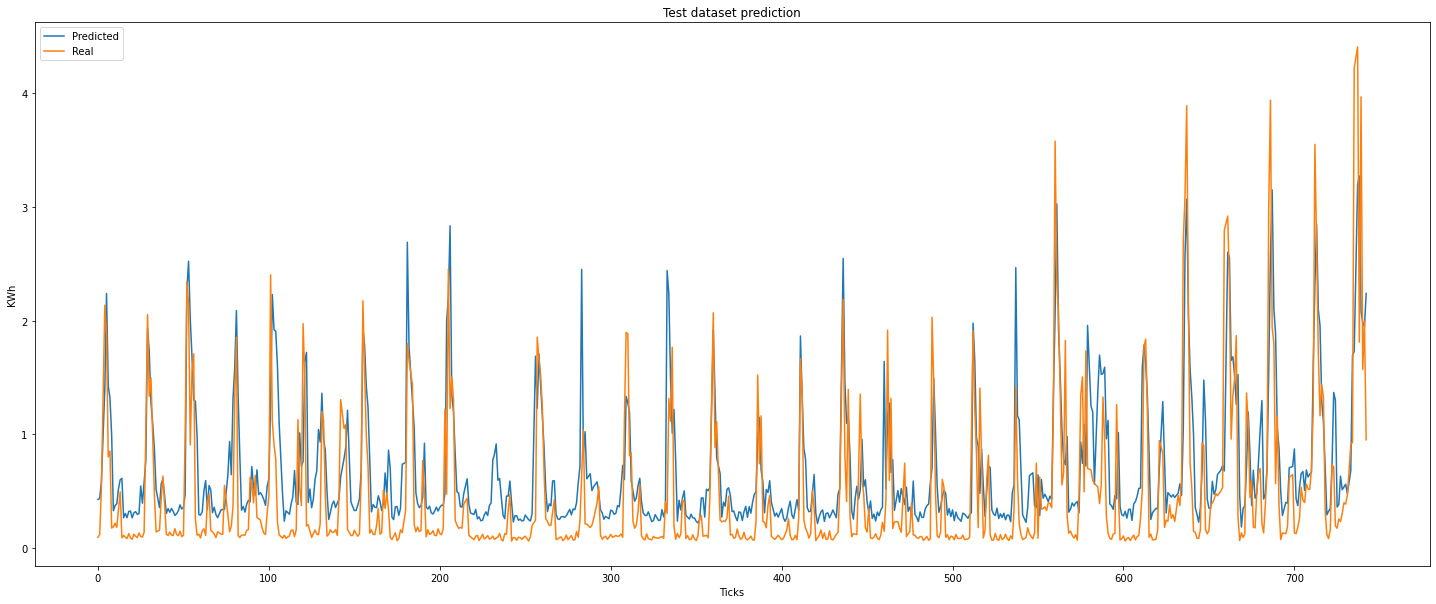

In [615]:
# plotting the result
plt.figure(figsize = (25,10))
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[:len(y_test[1])], pred_xg, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

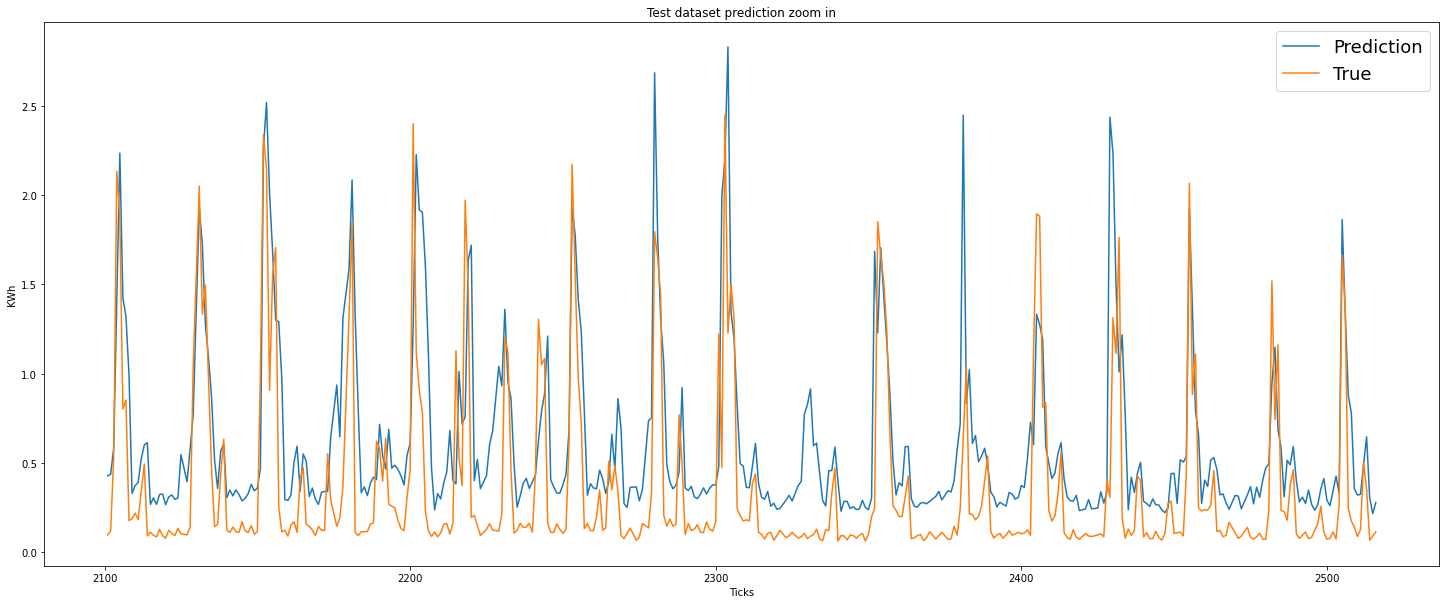

In [616]:
# zooming in
plt.plot(weather_energy.index[2000:2400], pred_xg[:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

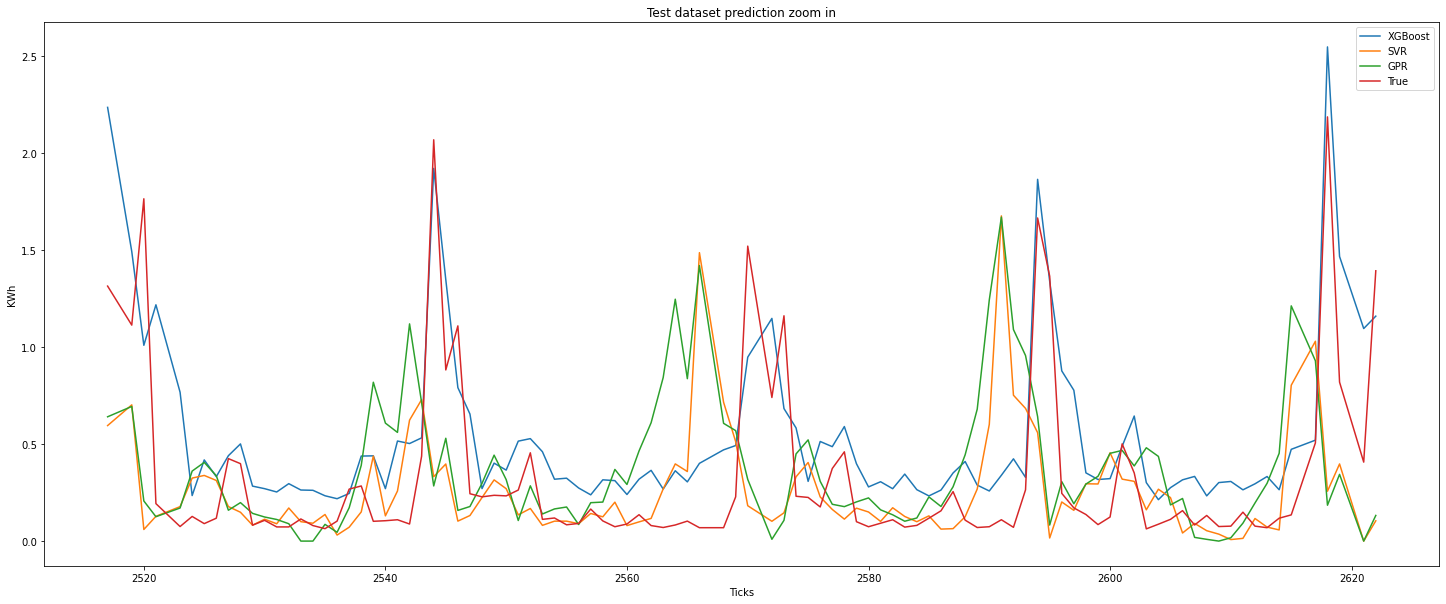

In [617]:
# zooming in and comparing with other algorithms
plt.plot(weather_energy.index[2400:2500], pred_xg[315:415], label = 'XGBoost')
plt.plot(weather_energy.index[2400:2500], predictions_svr[315:415], label = 'SVR')
plt.plot(weather_energy.index[2400:2500], predictions_gpr[0][315:415], label = 'GPR')
plt.plot(weather_energy.index[2400:2500],y_test[1][315:415], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [618]:
# metrics: MSE, R2, MAE, MDA
test_score = mean_squared_error(y_test[1], pred_xg)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.225


In [619]:
r2_score(y_test[1], pred_xg)

0.47773243093694084

In [620]:
mda(np.asarray(y_test[1]), pred_xg)

0.4971560904434464

In [621]:
test_score_mae = mean_absolute_error(y_test[1], pred_xg)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.345


### No outliers in train data

In [603]:
# same procedure as above
model = XGBRegressor(objective='reg:squarederror', n_estimators=400, min_child_weight=0.4, max_depth= 14, learning_rate= 0.02, gamma= 0.8)

In [604]:
model.fit(X_train_no_out[1], y_train_no_out[1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.8, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=14, min_child_weight=0.4, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [605]:
pred_xg = model.predict(X_test[1])

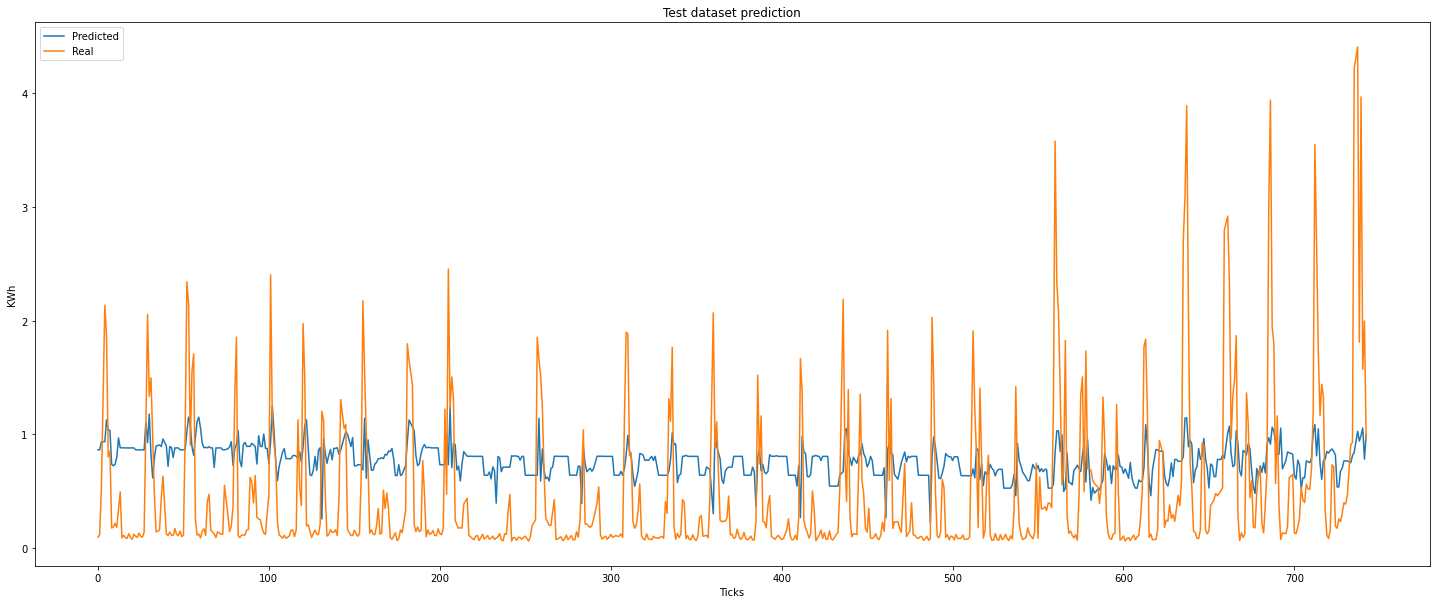

In [606]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[:len(y_test[1])], pred_xg, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

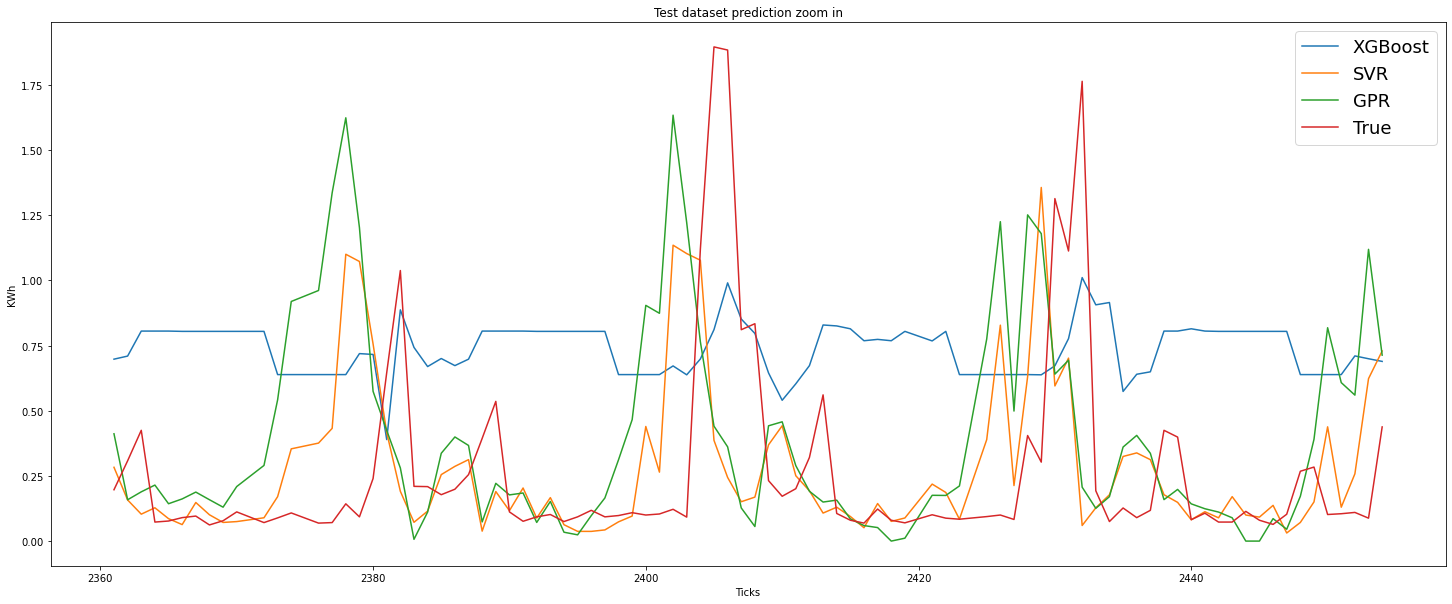

In [607]:
plt.plot(weather_energy.index[2250:2340], pred_xg[250:340], label = 'XGBoost')
plt.plot(weather_energy.index[2250:2340], predictions_svr[250:340], label = 'SVR')
plt.plot(weather_energy.index[2250:2340], predictions_gpr[0][250:340], label = 'GPR')
plt.plot(weather_energy.index[2250:2340],y_test[1][250:340], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

In [608]:
test_score = mean_squared_error(y_test[1], pred_xg)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.480


In [609]:
r2_score(y_test[1], pred_xg)

-0.11211214607011777

In [610]:
mda(np.asarray(y_test[1]), pred_xg)

0.3855995409044752

In [611]:
test_score_mae = mean_absolute_error(y_test[1], pred_xg)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.587


### No outliers in all data

In [592]:
# same procedure as above
model = XGBRegressor(objective='reg:squarederror', n_estimators=400, min_child_weight=0.4, max_depth= 14, learning_rate= 0.02, gamma= 0.8)

In [593]:
model.fit(X_train_filt[1], y_train_filt[1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.8, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=14, min_child_weight=0.4, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [594]:
pred_xg = model.predict(X_test_filt[1])

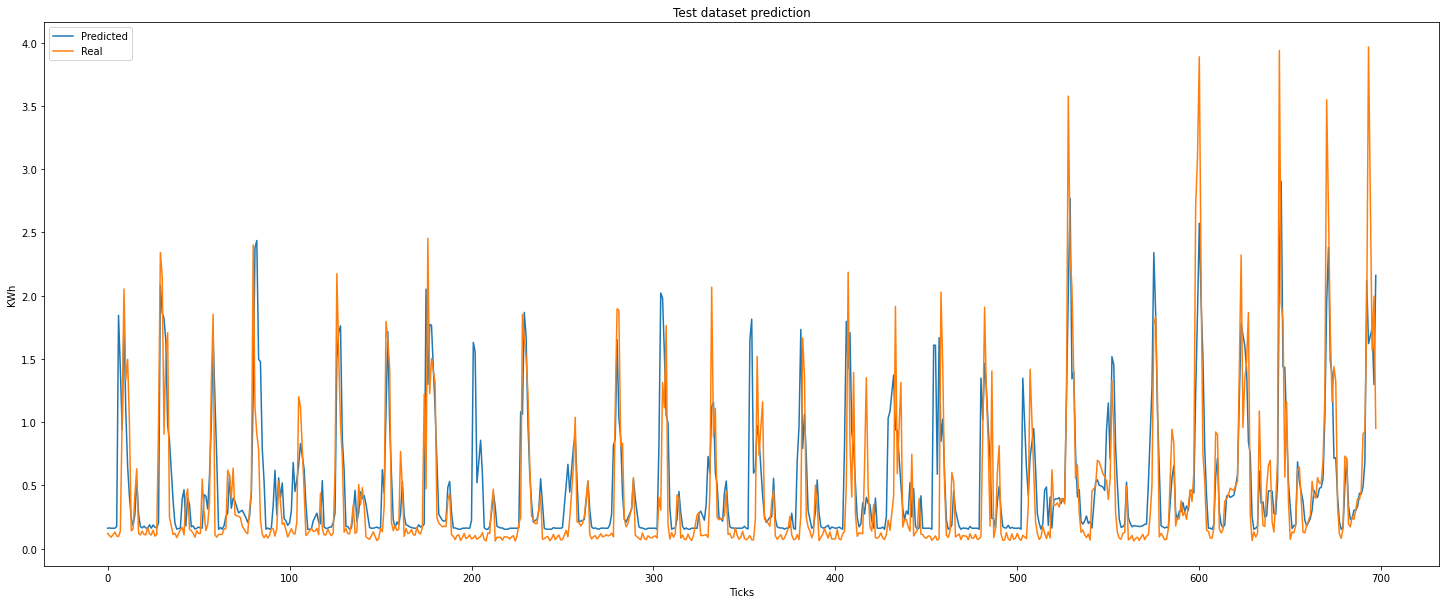

In [596]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[:len(y_test_filt[1])], pred_xg, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test_filt[1])],y_test_filt[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

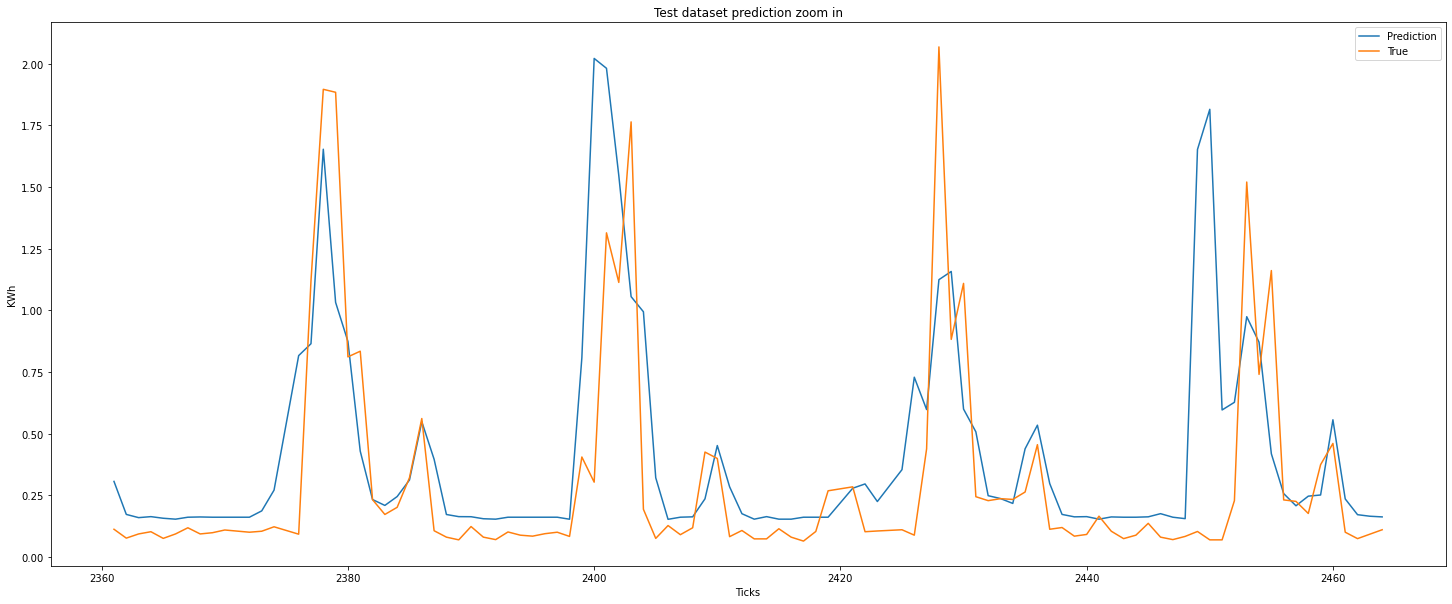

In [598]:
plt.plot(weather_energy.index[2250:2350], pred_xg[250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test_filt[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [599]:
test_score = mean_squared_error(y_test_filt[1], pred_xg)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.179


In [600]:
r2_score(y_test_filt[1], pred_xg)

0.4998094095171678

In [601]:
mda(np.asarray(y_test_filt[1]), pred_xg)

0.5462822458270106

In [602]:
test_score_mae = mean_absolute_error(y_test_filt[1], pred_xg)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.246


## LSTM

In [622]:
#
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional = True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [628]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [623]:
X_train_tensors = Variable(torch.Tensor(X_train[1].values))
X_test_tensors = Variable(torch.Tensor(X_test[1].values))

y_train_tensors = Variable(torch.Tensor(y_train[1].values)).cuda()
y_test_tensors = Variable(torch.Tensor(y_test[1].values)).cuda()

In [624]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])).cuda()

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])).cuda()

In [699]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.025 #0.025 lr

input_size = 24 #number of features
num_layers = 3 #number of stacked lstm layers
hidden_layers = 80 #number of hidden layers
num_classes = 1 #number of output classes 

In [700]:
model = LSTMModel(input_size, hidden_layers, num_layers, num_classes, 0.2).to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [701]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #outputs = outputs[0].squeeze(2)
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    scheduler.step()
   # if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
    

Epoch: 0, loss: 1.05976
Epoch: 1, loss: 0.64984
Epoch: 2, loss: 2.23094
Epoch: 3, loss: 0.37933
Epoch: 4, loss: 0.64149
Epoch: 5, loss: 0.76215
Epoch: 6, loss: 0.76903
Epoch: 7, loss: 0.71753
Epoch: 8, loss: 0.61361
Epoch: 9, loss: 0.47855
Epoch: 10, loss: 0.40095
Epoch: 11, loss: 0.40314
Epoch: 12, loss: 0.36431
Epoch: 13, loss: 0.34788
Epoch: 14, loss: 0.35326
Epoch: 15, loss: 0.32539
Epoch: 16, loss: 0.31264
Epoch: 17, loss: 0.32198
Epoch: 18, loss: 0.30500
Epoch: 19, loss: 0.29915
Epoch: 20, loss: 0.30670
Epoch: 21, loss: 0.30521
Epoch: 22, loss: 0.29355
Epoch: 23, loss: 0.29743
Epoch: 24, loss: 0.29082
Epoch: 25, loss: 0.28065
Epoch: 26, loss: 0.27852
Epoch: 27, loss: 0.27968
Epoch: 28, loss: 0.27364
Epoch: 29, loss: 0.26989
Epoch: 30, loss: 0.26605
Epoch: 31, loss: 0.25976
Epoch: 32, loss: 0.25976
Epoch: 33, loss: 0.25371
Epoch: 34, loss: 0.24885
Epoch: 35, loss: 0.24861
Epoch: 36, loss: 0.24321
Epoch: 37, loss: 0.24154
Epoch: 38, loss: 0.23678
Epoch: 39, loss: 0.22713
Epoch: 40,

Epoch: 330, loss: 0.01762
Epoch: 331, loss: 0.01763
Epoch: 332, loss: 0.01624
Epoch: 333, loss: 0.01806
Epoch: 334, loss: 0.01727
Epoch: 335, loss: 0.01667
Epoch: 336, loss: 0.01692
Epoch: 337, loss: 0.01773
Epoch: 338, loss: 0.01678
Epoch: 339, loss: 0.01727
Epoch: 340, loss: 0.01695
Epoch: 341, loss: 0.01738
Epoch: 342, loss: 0.01686
Epoch: 343, loss: 0.01661
Epoch: 344, loss: 0.01751
Epoch: 345, loss: 0.01723
Epoch: 346, loss: 0.01655
Epoch: 347, loss: 0.01701
Epoch: 348, loss: 0.01653
Epoch: 349, loss: 0.01573
Epoch: 350, loss: 0.01708
Epoch: 351, loss: 0.01663
Epoch: 352, loss: 0.01785
Epoch: 353, loss: 0.01646
Epoch: 354, loss: 0.01578
Epoch: 355, loss: 0.01703
Epoch: 356, loss: 0.01563
Epoch: 357, loss: 0.01720
Epoch: 358, loss: 0.01565
Epoch: 359, loss: 0.01471
Epoch: 360, loss: 0.01773
Epoch: 361, loss: 0.01720
Epoch: 362, loss: 0.01620
Epoch: 363, loss: 0.01641
Epoch: 364, loss: 0.01502
Epoch: 365, loss: 0.01878
Epoch: 366, loss: 0.01717
Epoch: 367, loss: 0.01741
Epoch: 368, 

Epoch: 647, loss: 0.00952
Epoch: 648, loss: 0.00897
Epoch: 649, loss: 0.00872
Epoch: 650, loss: 0.00877
Epoch: 651, loss: 0.00943
Epoch: 652, loss: 0.00839
Epoch: 653, loss: 0.00826
Epoch: 654, loss: 0.00875
Epoch: 655, loss: 0.00845
Epoch: 656, loss: 0.00929
Epoch: 657, loss: 0.00950
Epoch: 658, loss: 0.00986
Epoch: 659, loss: 0.00865
Epoch: 660, loss: 0.00988
Epoch: 661, loss: 0.00900
Epoch: 662, loss: 0.00878
Epoch: 663, loss: 0.00941
Epoch: 664, loss: 0.00893
Epoch: 665, loss: 0.01088
Epoch: 666, loss: 0.00973
Epoch: 667, loss: 0.01004
Epoch: 668, loss: 0.00915
Epoch: 669, loss: 0.00923
Epoch: 670, loss: 0.00888
Epoch: 671, loss: 0.00957
Epoch: 672, loss: 0.00837
Epoch: 673, loss: 0.01020
Epoch: 674, loss: 0.00914
Epoch: 675, loss: 0.01104
Epoch: 676, loss: 0.00876
Epoch: 677, loss: 0.00906
Epoch: 678, loss: 0.00941
Epoch: 679, loss: 0.00952
Epoch: 680, loss: 0.00974
Epoch: 681, loss: 0.00901
Epoch: 682, loss: 0.00930
Epoch: 683, loss: 0.00873
Epoch: 684, loss: 0.00933
Epoch: 685, 

Epoch: 969, loss: 0.00598
Epoch: 970, loss: 0.00735
Epoch: 971, loss: 0.00748
Epoch: 972, loss: 0.00678
Epoch: 973, loss: 0.00685
Epoch: 974, loss: 0.00670
Epoch: 975, loss: 0.00585
Epoch: 976, loss: 0.00645
Epoch: 977, loss: 0.00684
Epoch: 978, loss: 0.00653
Epoch: 979, loss: 0.00683
Epoch: 980, loss: 0.00711
Epoch: 981, loss: 0.00663
Epoch: 982, loss: 0.00670
Epoch: 983, loss: 0.00622
Epoch: 984, loss: 0.00627
Epoch: 985, loss: 0.00614
Epoch: 986, loss: 0.00657
Epoch: 987, loss: 0.00662
Epoch: 988, loss: 0.00588
Epoch: 989, loss: 0.00653
Epoch: 990, loss: 0.00672
Epoch: 991, loss: 0.00562
Epoch: 992, loss: 0.00606
Epoch: 993, loss: 0.00710
Epoch: 994, loss: 0.00647
Epoch: 995, loss: 0.00670
Epoch: 996, loss: 0.00714
Epoch: 997, loss: 0.00698
Epoch: 998, loss: 0.00647
Epoch: 999, loss: 0.00623


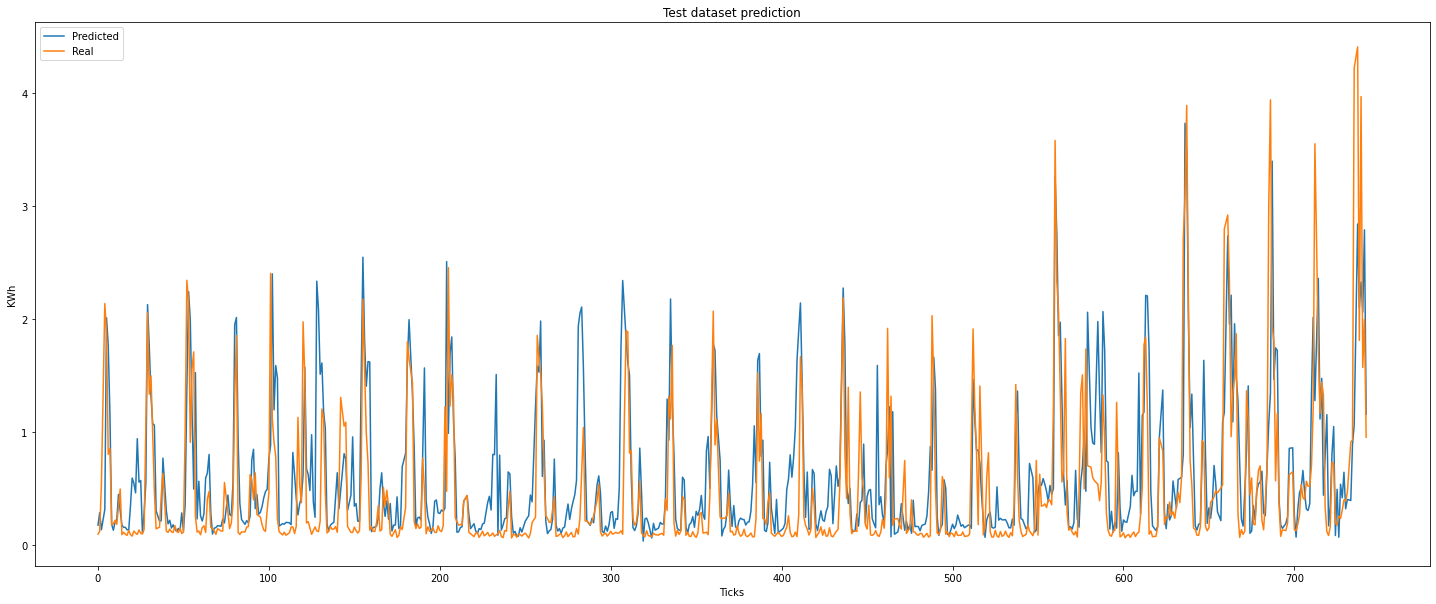

In [707]:
test_predict = model(X_test_tensors_final)#forward pass
data_predict = test_predict.cpu().data.numpy() #numpy conversion
#data_predict = mm.inverse_transform(data_predict) #reverse transformation

plt.figure(figsize = (25,10))

plt.plot(weather_energy.index[:len(y_test[1])], data_predict, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [708]:
#metrics: MSE, R2, MDA, MAE
test_score = mean_squared_error(y_test[1], data_predict)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.284


In [709]:
r2_score(y_test[1], data_predict)

0.3416272739052054

In [710]:
mda(np.asarray(y_test[1]), data_predict)

0.5691868758915835

In [711]:
test_score_mae = mean_absolute_error(y_test[1], data_predict)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.329


# Meta Learning

In [746]:
# function that imitates scipy optimizer for GPR algorithm (needed for MAML meta learning algorithm)
def constrained_optimization(self, obj_func, inner_step_size, outer_step_size, iterations, kernel, X_train, y_train, tasks, initial_theta, bounds):
    theta = initial_theta
    for iteration in range(iterations):
        lml, grad = obj_func(initial_theta, inner_step_size, kernel, X_train, y_train, eval_gradient=True) #inner loop
        for i in range(len(grad)):
            theta[i] = theta[i] - outer_step_size*grad[i] # gradient update of the outer loop
        outer_step_size = outer_step_size * (1 - iteration/iterations) # scheduling of learning rate
    theta_opt = theta
    return theta_opt

In [747]:
# objective function to optimize (inner loop objective function for MAML)
def obj_func(theta, inner_step_size, kernel, X_train, y_train, tasks = 35, eval_gradient=True):
    lml_tot = 0
    grad_tot = 0
    for task in range(tasks):
        kernel.theta = theta
        gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train[task], y_train[task])
        lml, grad = gpr.log_marginal_likelihood(
            theta, eval_gradient=True, clone_kernel=False) #getting marginal likelihood and its grad for every task
        for i in range(len(grad)):
            theta[i] = theta[i] + inner_step_size*grad[i]  #inner loop gradient update
        lml_tot += lml
        grad_tot += grad  
    return -lml_tot, -grad_tot

In [714]:
# function that imitates scipy optimizer for GPR algorithm (needed for Reptile meta learning algorithm)
def constrained_optimization_rept(self, obj_func, inner_step_size, outer_step_size, iterations, kernel, X_train, y_train, tasks, initial_theta, bounds):
    theta = initial_theta
    for iteration in range(iterations):
        theta_new = obj_func_rept(initial_theta,kernel, inner_step_size, X_train, y_train, tasks, eval_gradient=True)
        theta = theta + outer_step_size*(theta_new - theta) #Reptile gradient update for outer loop
        outer_step_size = outer_step_size * (1 - iteration/iterations) #Scheduling of the learning rate
    theta_opt = theta
    return theta_opt

In [715]:
# objective function to optimize (inner loop objective function for Reptile)
def obj_func_rept(theta,kernel, inner_step_size, X_train, y_train, tasks, eval_gradient=True):
    lml_tot = 0
    grad_tot = 0
    if eval_gradient:
        random_order = np.random.permutation(tasks)
        for task in range(tasks):
            indicies = random_order[task]
            kernel.theta = theta
            gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train[indicies], y_train[indicies])
            lml, grad = gpr.log_marginal_likelihood(
                theta, eval_gradient=True, clone_kernel=False)
            for i in range(len(grad)):
                theta[i] = theta[i] + inner_step_size*grad[i] 
        return theta

In [672]:
# Meta Learning class implementation for Deep Learning
class Meta_Learning:
    def __init__(self, model):
        self.model = model.to(device)
    
    def train_maml(self, iterations, outer_step_size, inner_step_size, 
        inner_gradient_steps, X_train, y_train, X_query, y_query, tasks=10):
        loss = 0
        batches = 0
        for iteration in range(iterations):
            init_weights = deepcopy(self.model.state_dict())
            x_test = X_query.values
            y_test = y_query.values
            meta_params = {}
            for task in range(tasks): 
                # sample for meta-update
                x = X_train[task].values
                y = y_train[task].values
                #y = mm.transform(y) 
                for grad_step in range(inner_gradient_steps):
                    loss_base = self.train_loss(x,y)
                    loss_base.backward()
                    for param in self.model.parameters():
                        param.data -= inner_step_size * param.grad.data
                loss_meta = self.train_loss(x_test, y_test)
                loss_meta.backward()
                for name,param in self.model.named_parameters():
                    if(task == 0):
                        meta_params[name] =  param.grad.data
                    else:
                        meta_params[name] += param.grad.data
                loss += loss_meta.cpu().data.numpy()
                batches += 1
                self.model.load_state_dict(init_weights)
            learning_rate = outer_step_size * (1 - iteration/iterations)
            print(loss/batches, iteration)
            self.model.load_state_dict({name: init_weights[name] - 
                learning_rate/tasks * meta_params[name] for name in init_weights})

    def train_reptile(self, iterations, outer_step_size, inner_step_size, 
        inner_gradient_steps, X_train, y_train, X_query, y_query, tasks=10):
        loss = 0
        batches=0
        for iteration in range(iterations):
            init_weights = deepcopy(self.model.state_dict())
            for j in range(inner_gradient_steps):
                random_order = np.random.permutation(tasks)
                for start in range(0,tasks):
                    indicies = random_order[start]
                    y = y_train[indicies].values
                    #y = mm.transform(y)
                    loss_base = self.train_loss(X_train[indicies].values, y)
                    loss_base.backward()
                    for param in self.model.parameters():
                        param.data -= inner_step_size * param.grad.data
                    loss += loss_base.cpu().data.numpy()
                    batches += 1
            learning_rate = outer_step_size * (1 - iteration/iterations)
            curr_weights = self.model.state_dict()
            print(loss/batches, iteration)
            self.model.load_state_dict({name: (init_weights[name] + learning_rate * 
                (curr_weights[name] - init_weights[name])) for name in curr_weights})

    def train_loss(self, x, y):
        x = torch.tensor(x, dtype=torch.float32, device = device)
        y = torch.tensor(y, dtype=torch.float32, device = device)
        x = x[:, None, :]
        self.model.zero_grad()
        out = self.model(x)
        #MSE, MAE and LogLoss 
        #loss = (out - y).pow(2).mean()
        #loss = abs((out - y)).mean()
        loss = torch.sqrt(torch.mean(torch.pow((torch.log(y + 1) - torch.log(out + 1)),2)))
        return loss

    def evaluate(self, y_all, x_all, outer_step_size = 0.2, gradient_steps=10, inner_step_size=0.02):
        pred = [self.predict(x_all.values)]
        meta_weights = deepcopy(self.model.state_dict())
        params = {}
        for i in range(gradient_steps):
            loss_base = self.train_loss(x_all.values,y_all)
            loss_base.backward()
            for param in self.model.parameters():
                param.data -= inner_step_size * param.grad.data
            pred.append(self.predict(x_all.values))
        for name,param in self.model.named_parameters():
            params[name] =  param.grad.data
        self.model.load_state_dict({name: meta_weights[name] - 
                outer_step_size * params[name] for name in meta_weights})
        return {"pred": pred}

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32, device=device)
        x = x[:, None, :]
        return self.model(x).cpu().data.numpy()
class Meta_Wave(nn.Module):
    def __init__(self, units):
        super(Meta_Wave, self).__init__()
        self.inp = nn.Linear(24, units)
        self.layer1 = nn.Linear(units,units)
        self.out = nn.Linear(units, 1)

    def forward(self,x):
        x = torch.tanh(self.inp(x))
        x = torch.tanh(self.layer1(x))
        output = self.out(x)
        return output

In [787]:
# Data preparation for Meta Learning
X_train_meta = []
y_train_meta = []
X_val_meta_dl = []
y_val_meta_dl = []
X_query_meta = []
y_query_meta = []
for i in range(len(ds)): 
    X_train_meta.append(X_train[i].sample(200, random_state = 0))
    y_train_meta.append(y_train[i].sample(200, random_state = 0))
    X_val_meta_dl.append(X_train[i].sample(50, random_state = 100))
    y_val_meta_dl.append(y_train[i].sample(50, random_state = 100))
    X_query_meta.append(X_train[i].sample(100, random_state = 10))
    y_query_meta.append(y_train[i].sample(100, random_state = 10))

In [788]:
# concatenating values for DL models
X_val_meta_dl = pd.concat(X_val_meta_dl)
y_val_meta_dl = pd.concat(y_val_meta_dl)

### GPR models

In [826]:
# parameters
init_ls = 0.5
init_nl = 0.2
tasks = 40
# reptile parameters
inner_step_size_rept = 0.01
outer_step_size_rept = 0.2
iterations_rept = 25
# MAML parameters
inner_step_size_maml = 0.01
outer_step_size_maml = 0.01
iterations_maml = 25

In [833]:
# Concatenating inputs into a single matrix for training on all samples
X_train_meta_gpr = pd.concat(X_train_meta)
y_train_meta_gpr = pd.concat(y_train_meta)
kernels_gpr = kernels.RBF(length_scale = init_ls) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = inite_nl)
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train_meta_gpr, y_train_meta_gpr)
kernels_gpr = kernels_gpr.set_params(**(model.kernel_.get_params()))
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_query_meta[1], y_query_meta[1])
gprscore = model.score(X_train[1], y_train[1])
print(gprscore)

0.30650916425451735


In [825]:
# Reptile GPR
kernels_gpr = kernels.RBF(length_scale = init_ls,  length_scale_bounds=(1e-06, 1000000.0)) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = init_nl)
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0)
theta_opt = constrained_optimization_rept(model,obj_func, inner_step_size_rept, outer_step_size_rept, iterations_rept, kernels_gpr, X_train_meta, 
                                     y_train_meta, tasks, initial_theta = model.kernel.theta, bounds = model.kernel.bounds)
# fixing kernel to resulting meta learning kernel
model.kernel.theta = theta_opt

# Adjusting model for a particular household
model = GaussianProcessRegressor(kernel=model.kernel, random_state=0).fit(X_query_meta[1], y_query_meta[1])
gprscore = model.score(X_train[1], y_train[1])
print(gprscore)

C:\Users\denis\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\denis\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.30650714929931067


In [839]:
#MAML GPR
kernels_gpr = kernels.RBF(length_scale = init_ls, length_scale_bounds=(1e-06, 1000000.0)) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = init_nl) 
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0)
theta_opt = constrained_optimization(model,obj_func, inner_step_size_maml, outer_step_size_maml, iterations_maml, kernels_gpr, X_train_meta, 
                                     y_train_meta, tasks, initial_theta = model.kernel.theta, bounds = model.kernel.bounds)
# fixing kernel to resulting meta learning kernel
model.kernel.theta = theta_opt

# Adjusting model for a particular household
model = GaussianProcessRegressor(kernel=model.kernel, random_state=0).fit(X_query_meta[1], y_query_meta[1])
gprscore = model.score(X_train[1], y_train[1])
print(gprscore)

0.4892748496678544


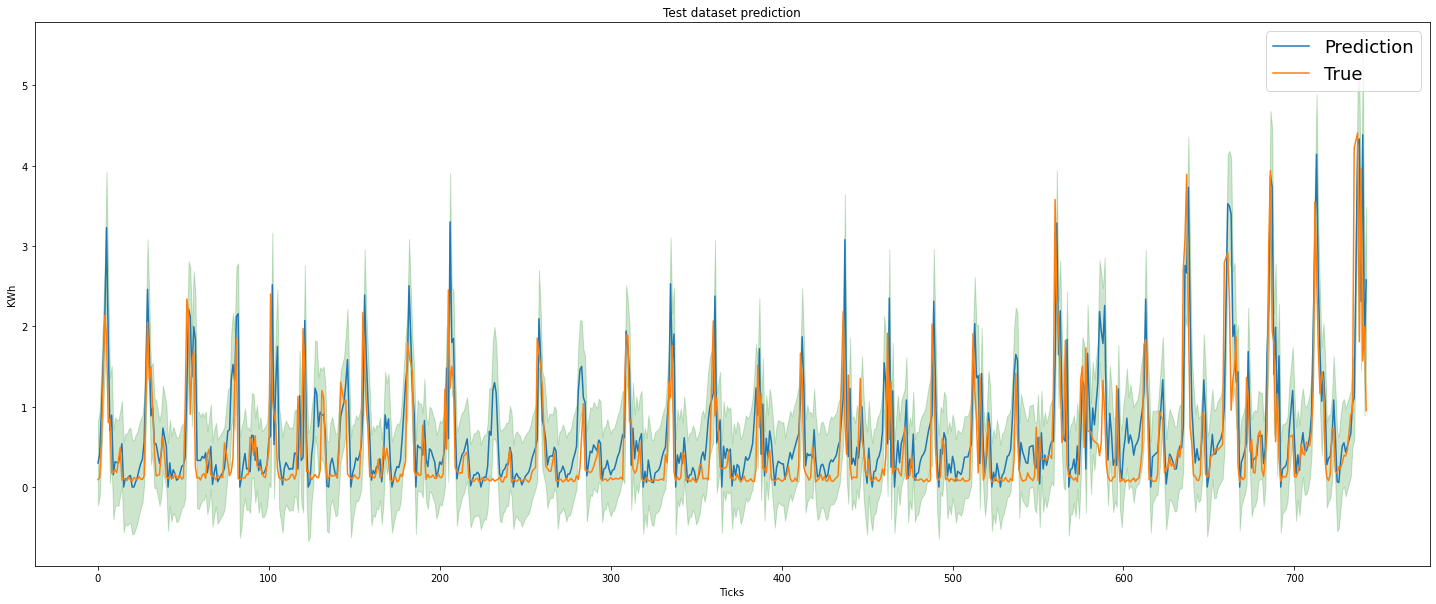

In [840]:
# Test predictions
predictions_gpr = model.predict(X_test[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[:len(predictions_gpr[0])], predictions_gpr[0], label = 'Prediction')
plt.plot(weather_energy.index[:len(predictions_gpr[0])],y_test[1], label = 'True')
plt.fill_between(weather_energy.index[:len(predictions_gpr[0])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

In [841]:
# metrics: MSE, MAE, R2, MDA
test_score = mean_squared_error(y_test[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.328


In [842]:
r2_score(y_test[1], predictions_gpr[0])

0.23903399324773011

In [843]:
test_score_mae = mean_absolute_error(y_test[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.373


In [844]:
mda(np.asarray(y_test[1]), predictions_gpr[0])

0.5335235378031383

### Deep Learning models

In [786]:
# parameters 
n_epochs = 1000
external_step_size = 0.4
internal_step_size = 0.02
inner_grad_steps = 1
#lstm parameters
input_size = 24   #number of features
num_layers = 1    #number of stacked lstm layers
hidden_size = 50  #hidden layer size
num_classes = 1   #number of output classes 
dropout_prob = 0.1

In [807]:
#model = Meta_Wave(128)
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout_prob).to(device)
meta = Meta_Learning(model)
# Training via Reptile algorithm
meta.train_reptile(n_epochs, external_step_size, internal_step_size,inner_grad_steps, 
                X_train_meta, y_train_meta, X_val_meta_dl, y_val_meta_dl, tasks)
# Uncomment next lines, to train through MAML algorithm
# meta.train_maml(n_epochs, external_step_size, internal_step_size,inner_grad_steps, 
#                 X_train_meta, y_train_meta, X_val_meta_dl, y_val_meta_dl, tasks)

C:\Users\denis\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0.5912415340542794 0
0.5865731403231621 1
0.5820661574602127 2
0.5777122180908918 3
0.573504626750946 4
0.5694364935159684 5
0.5655016931039947 6
0.5616943344473839 7
0.5580089029338625 8
0.554440354257822 9
0.5509838509288701 10
0.5476348130653302 11
0.5443889896457011 12
0.5412422900753362 13
0.5381908225019773 14
0.535230946727097 15
0.5323591041214326 16
0.5295719955944352 17
0.5268664350242991 18
0.5242392914369702 19
0.521687695064715 20
0.5192088699476285 21
0.5168001276319442 22
0.5144588876515627 23
0.5121827524006367 24
0.5099693485750602 25
0.5078164316989757 26
0.5057218760251999 27
0.5036835880115115 28
0.5016996096074581 29
0.4997680491257098 30
0.497887072712183 31
0.4960549666574507 32
0.4942700235940078 33
0.49253066441842486 34
0.490835341397259 35
0.48918256803944304 36
0.4875709515653158 37
0.48599911593855954 38
0.4844657385163009 39
0.48296956060136237 40
0.4815093938793455 41
0.4800840503947679 42
0.4786924496631731 43
0.47733348652720453 44
0.4760061222088078 45

0.3877056626942144 356
0.387634064742057 357
0.3875627691180427 358
0.38749177324275175 359
0.3874210745323233 360
0.38735067117856353 361
0.38728056146093637 362
0.3872107430269102 363
0.38714121333948553 364
0.3870719725113423 365
0.38700301679668375 366
0.386934345294519 367
0.38686595575273197 368
0.38679784564955816 369
0.38673001387811734 370
0.38666245885473743 371
0.3865951786192269 372
0.3865281713100519 373
0.38646143542726835 374
0.38639496794327144 375
0.386328768726211 376
0.38626283525671595 377
0.3861971657811652 378
0.38613175969178737 379
0.3860666137843777 380
0.386001727103953 381
0.38593709765503054 382
0.38587272448154786 383
0.385808605787816 384
0.38574473969638345 385
0.38568112412587924 386
0.38561775803220333 387
0.3855546399682837 388
0.38549176851526284 389
0.38542914175621384 390
0.3853667582043124 391
0.38530461681442707 392
0.38524271568595453 393
0.38518105370711675 394
0.38511962830606433 395
0.3850584397575717 396
0.38499748496591446 397
0.384936763592

0.3730592297526908 707
0.373034711643444 708
0.37301025099212853 709
0.37298584686469094 710
0.37296149965919806 711
0.37293720885191695 712
0.3729129742570117 713
0.3728887961315108 714
0.3728646742419324 715
0.37284060794252233 716
0.3728165970622331 717
0.3727926419926121 718
0.3727687418202145 719
0.3727448968260695 720
0.3727211066529444 721
0.3726973711063423 722
0.3726736904785696 723
0.3726500640460129 724
0.37262649149954646 725
0.3726029730820836 726
0.37257950843240206 727
0.3725560973885128 728
0.3725327397842113 729
0.3725094355683565 730
0.3724861844651442 731
0.3724629864818321 732
0.37243984108562367 733
0.37241674818554704 734
0.37239370750992196 735
0.3723707193748841 736
0.37234778355372955 737
0.37232489953666964 738
0.3723020671116742 739
0.3722792863886044 740
0.3722565574204986 741
0.3722338796504253 742
0.3722112528258754 743
0.37218867705472364 744
0.372166152216554 745
0.3721436779801466 746
0.3721212539831824 747
0.3720988804660986 748
0.3720765571564436 749


In [808]:
# adjusting model for query input
meta.evaluate(y_query_meta[1].values, X_query_meta[1], outer_step_size = 0.5)

{'pred': [array([[0.7776522 ],
         [0.56199324],
         [1.041786  ],
         [0.4291957 ],
         [0.55448186],
         [0.42895216],
         [0.5854341 ],
         [0.39238977],
         [1.252377  ],
         [0.52426195],
         [0.5646604 ],
         [0.5825877 ],
         [0.7267919 ],
         [0.62688065],
         [0.8704684 ],
         [0.36303782],
         [0.6561442 ],
         [0.67359316],
         [0.6022559 ],
         [0.58301187],
         [0.44626766],
         [0.66853696],
         [0.42369348],
         [0.69935024],
         [0.5299674 ],
         [0.6199059 ],
         [0.6045855 ],
         [0.94115424],
         [1.3358316 ],
         [0.4777636 ],
         [0.5821294 ],
         [0.50877786],
         [0.71472085],
         [0.5245785 ],
         [0.5695467 ],
         [0.81584513],
         [0.58261234],
         [0.6465468 ],
         [0.685796  ],
         [1.1745266 ],
         [0.5133646 ],
         [0.46461546],
         [0.44638163],
   

In [809]:
# predicting for test values
pred = meta.predict(X_test[1].values)
data_predict = pred

In [810]:
# clipping values at 0
for i in range(len(data_predict)):
    if data_predict[i] < 0:
        data_predict[i] = 0

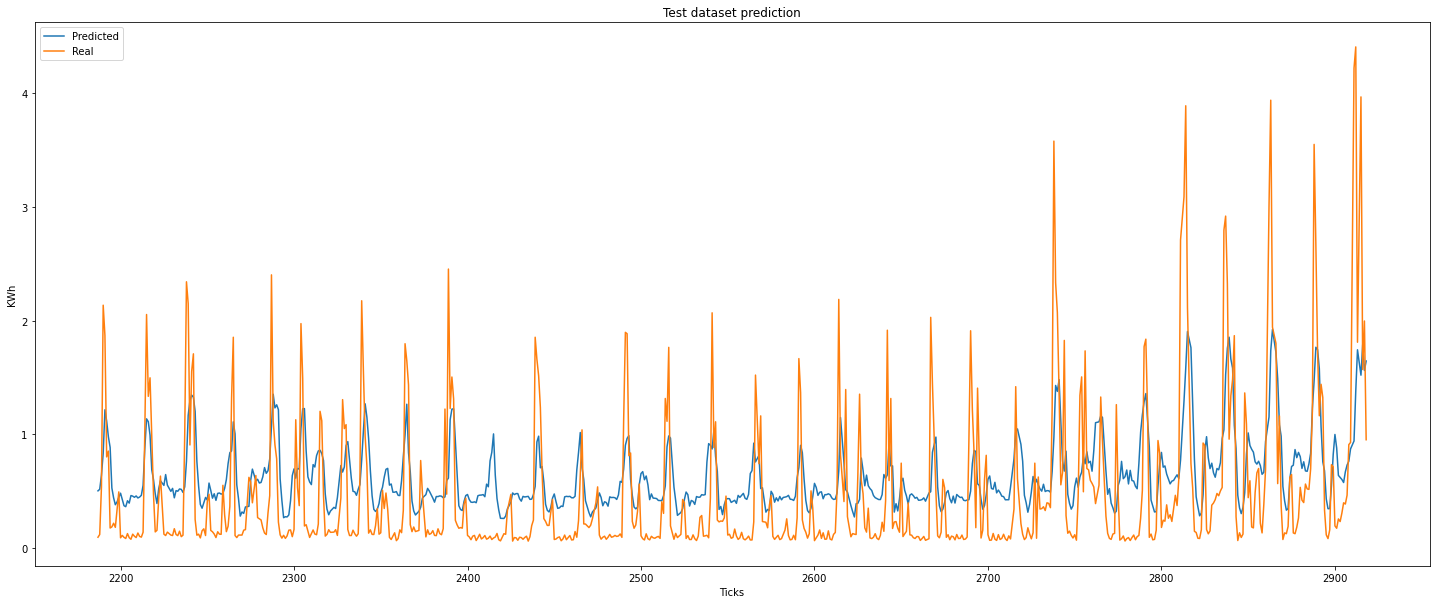

In [811]:
#plotting output
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[2082:2784], data_predict, label = 'Predicted')
plt.plot(weather_energy.index[2082:2784],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [812]:
test_score = mean_squared_error(y_test[1], data_predict)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.286


In [813]:
r2_score(y_test[1], data_predict)

0.33761082125096376

# LSTM Meta Learner

In [1058]:
# utilities functions
def save_ckpt(episode, metalearner, optim, save):
    if not os.path.exists(os.path.join(save, 'ckpts')):
        os.mkdir(os.path.join(save, 'ckpts'))

    torch.save({
        'episode': episode,
        'metalearner': metalearner.state_dict(),
        'optim': optim.state_dict()
    }, os.path.join(save, 'ckpts', 'meta-learner-{}.pth.tar'.format(episode)))


def resume_ckpt(metalearner, optim, resume, device):
    ckpt = torch.load(resume, map_location=device)
    last_episode = ckpt['episode']
    metalearner.load_state_dict(ckpt['metalearner'])
    optim.load_state_dict(ckpt['optim'])
    return last_episode, metalearner, optim


def preprocess_grad_loss(x):
    p = 10
    indicator = (x.abs() >= np.exp(-p)).to(torch.float32)

    # preproc1
    x_proc1 = indicator * torch.log(x.abs() + 1e-8) / p + (1 - indicator) * -1
    # preproc2
    x_proc2 = indicator * torch.sign(x) + (1 - indicator) * np.exp(p) * x
    return torch.stack((x_proc1, x_proc2), 1)

In [1059]:
# Meta Learner module definition
class MetaLSTMCell(nn.Module):
    """C_t = f_t * C_{t-1} + i_t * \tilde{C_t}"""
    def __init__(self, input_size, hidden_size, n_learner_params):
        super(MetaLSTMCell, self).__init__()
        """Args:
            input_size (int): cell input size, default = 20
            hidden_size (int): should be 1
            n_learner_params (int): number of learner's parameters
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_learner_params = n_learner_params
        self.WF = nn.Parameter(torch.Tensor(input_size + 2, hidden_size))
        self.WI = nn.Parameter(torch.Tensor(input_size + 2, hidden_size))
        self.cI = nn.Parameter(torch.Tensor(n_learner_params, 1))
        self.bI = nn.Parameter(torch.Tensor(1, hidden_size))
        self.bF = nn.Parameter(torch.Tensor(1, hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        for weight in self.parameters():
            nn.init.uniform_(weight, -0.01, 0.01)

        # want initial forget value to be high and input value to be low so that 
        #  model starts with gradient descent
        nn.init.uniform_(self.bF, 4, 6)
        nn.init.uniform_(self.bI, -5, -4)

    def init_cI(self, flat_params):
        self.cI.data.copy_(flat_params.unsqueeze(1))

    def forward(self, inputs, hx=None):
        """Args:
            inputs = [x_all, grad]:
                x_all (torch.Tensor of size [n_learner_params, input_size]): outputs from previous LSTM
                grad (torch.Tensor of size [n_learner_params]): gradients from learner
            hx = [f_prev, i_prev, c_prev]:
                f (torch.Tensor of size [n_learner_params, 1]): forget gate
                i (torch.Tensor of size [n_learner_params, 1]): input gate
                c (torch.Tensor of size [n_learner_params, 1]): flattened learner parameters
        """
        x_all, grad = inputs
        batch, _ = x_all.size()

        if hx is None:
            f_prev = torch.zeros((batch, self.hidden_size)).to(self.WF.device)
            i_prev = torch.zeros((batch, self.hidden_size)).to(self.WI.device)
            c_prev = self.cI
            hx = [f_prev, i_prev, c_prev]

        f_prev, i_prev, c_prev = hx
        
        # f_t = sigmoid(W_f * [grad_t, loss_t, theta_{t-1}, f_{t-1}] + b_f)
        f_next = torch.mm(torch.cat((x_all, c_prev, f_prev), 1), self.WF) + self.bF.expand_as(f_prev)
        # i_t = sigmoid(W_i * [grad_t, loss_t, theta_{t-1}, i_{t-1}] + b_i)
        i_next = torch.mm(torch.cat((x_all, c_prev, i_prev), 1), self.WI) + self.bI.expand_as(i_prev)
        # next cell/params
        c_next = torch.sigmoid(f_next).mul(c_prev) - torch.sigmoid(i_next).mul(grad)

        return c_next, [f_next, i_next, c_next]

    def extra_repr(self):
        s = '{input_size}, {hidden_size}, {n_learner_params}'
        return s.format(**self.__dict__)


class MetaLearner(nn.Module):

    def __init__(self, input_size, hidden_size, n_learner_params):
        super(MetaLearner, self).__init__()
        """Args:
            input_size (int): for the first LSTM layer, default = 4
            hidden_size (int): for the first LSTM layer, default = 20
            n_learner_params (int): number of learner's parameters
        """
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        self.metalstm = MetaLSTMCell(input_size=hidden_size, hidden_size=1, n_learner_params=n_learner_params)

    def forward(self, inputs, hs=None):
        """Args:
            inputs = [loss, grad_prep, grad]
                loss (torch.Tensor of size [1, 2])
                grad_prep (torch.Tensor of size [n_learner_params, 2])
                grad (torch.Tensor of size [n_learner_params])
            hs = [(lstm_hn, lstm_cn), [metalstm_fn, metalstm_in, metalstm_cn]]
        """
        loss, grad_prep, grad = inputs
        loss = loss.expand_as(grad_prep)
        inputs = torch.cat((loss, grad_prep), 1)   # [n_learner_params, 4]

        if hs is None:
            hs = [None, None]

        lstmhx, lstmcx = self.lstm(inputs, hs[0])
        flat_learner_unsqzd, metalstm_hs = self.metalstm([lstmhx, grad], hs[1])

        return flat_learner_unsqzd.squeeze(), [(lstmhx, lstmcx), metalstm_hs]

In [1060]:
# Learner module definition
class Learner(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(Learner, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.model = nn.ModuleDict({'features': nn.Sequential(OrderedDict([
            ('lstm', nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional = True))]))})
        self.model.update({'linear': nn.Linear(hidden_dim*2, output_dim)})
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out = self.model.features(x)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out = out[0].squeeze(2)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.model.linear(out)

        return out
    def get_flat_params(self):
        return torch.cat([p.view(-1) for p in self.model.parameters()], 0)

    def copy_flat_params(self, cI):
        idx = 0
        for p in self.model.parameters():
            plen = p.view(-1).size(0)
            p.data.copy_(cI[idx: idx+plen].view_as(p))
            idx += plen

    def transfer_params(self, learner_w_grad, cI):
        # Use load_state_dict only to copy the running mean/var in batchnorm, the values of the parameters
        #  are going to be replaced by cI
        self.load_state_dict(learner_w_grad.state_dict())
        #  replace nn.Parameters with tensors from cI (NOT nn.Parameters anymore).
        idx = 0
        for m in self.model.modules():            
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
                wlen = m._parameters['weight'].view(-1).size(0)
                m._parameters['weight'] = cI[idx: idx+wlen].view_as(m._parameters['weight']).clone()
                idx += wlen
                if m._parameters['bias'] is not None:
                    blen = m._parameters['bias'].view(-1).size(0)
                    m._parameters['bias'] = cI[idx: idx+blen].view_as(m._parameters['bias']).clone()
                    idx += blen
            if isinstance(m, nn.LSTM):
                wlen = m._parameters['weight_ih_l0'].view(-1).size(0)
                m._parameters['weight_ih_l0'] = cI[idx: idx+wlen].view_as(m._parameters['weight_ih_l0']).clone()
                idx += wlen
                if m._parameters['weight_hh_l0'] is not None:
                    blen = m._parameters['weight_hh_l0'].view(-1).size(0)
                    m._parameters['weight_hh_l0'] = cI[idx: idx+blen].view_as(m._parameters['weight_hh_l0']).clone()
                    idx += blen
                if m._parameters['bias_ih_l0'] is not None:
                    blen = m._parameters['bias_ih_l0'].view(-1).size(0)
                    m._parameters['bias_ih_l0'] = cI[idx: idx+blen].view_as(m._parameters['bias_ih_l0']).clone()
                    idx += blen
                if m._parameters['bias_hh_l0'] is not None:
                    blen = m._parameters['bias_hh_l0'].view(-1).size(0)
                    m._parameters['bias_hh_l0'] = cI[idx: idx+blen].view_as(m._parameters['bias_hh_l0']).clone()
                    idx += blen

    def reset_batch_stats(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.reset_running_stats()

In [1068]:
# Train learner 
def train_learner(learner_w_grad, metalearner, train_input, train_target, epoch, batch_size):
    cI = metalearner.metalstm.cI.data
    hs = [None]
    for _ in range(epoch):
        for i in range(0, len(train_input), batch_size):
            x = train_input[i:i+batch_size]
            y = train_target[i:i+batch_size]
            # get the loss/grad
            learner_w_grad.copy_flat_params(cI)
            output = learner_w_grad(x)
            loss = learner_w_grad.criterion(output.squeeze(2), y)
            learner_w_grad.zero_grad()
            loss.backward()
            grad = torch.cat([p.grad.data.view(-1) / batch_size for p in learner_w_grad.parameters()], 0)

            # preprocess grad & loss and metalearner forward
            grad_prep = preprocess_grad_loss(grad)  # [n_learner_params, 2]
            loss_prep = preprocess_grad_loss(loss.data.unsqueeze(0)) # [1, 2]
            metalearner_input = [loss_prep, grad_prep, grad.unsqueeze(1)]
            cI, h = metalearner(metalearner_input, hs[-1])
            hs.append(h)


    return cI


seed = random.randint(0, 1e3)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cpu')

# Set up learner, meta-learner
learner_w_grad = Learner(24, 50, 3, 1, 0.2).to(device)
learner_wo_grad = copy.deepcopy(learner_w_grad)
metalearner = MetaLearner(4, 1, learner_w_grad.get_flat_params().size(0)).to(device)
metalearner.metalstm.init_cI(learner_w_grad.get_flat_params())

# Set up loss, optimizer, learning rate scheduler
optim = torch.optim.Adam(metalearner.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.9)
# Meta-training
for task in range(len(X_train)):
    train_input =  Variable(torch.tensor(X_train_meta[task].values, dtype=torch.float32, device = device))
    train_input =  torch.reshape(train_input, (train_input.shape[0], 1, train_input.shape[1]))

    train_target = Variable(torch.tensor((y_train_meta[task].values), dtype=torch.float32, device = device))
    test_input = Variable(torch.tensor(X_val_meta_dl[task].values, dtype=torch.float32, device = device))
    test_input = torch.reshape(test_input,   (test_input.shape[0], 1, test_input.shape[1]))

    test_target = Variable(torch.tensor((y_val_meta_dl[task].values), dtype=torch.float32, device = device))

    # Train learner with metalearner
    learner_w_grad.reset_batch_stats()
    learner_wo_grad.reset_batch_stats()
    learner_w_grad.train()
    learner_wo_grad.train()
    cI = train_learner(learner_w_grad, metalearner, train_input, train_target, 500, 100)

    # Train meta-learner with validation loss
    learner_wo_grad.transfer_params(learner_w_grad, cI)
    output = learner_wo_grad(test_input)
    loss = learner_wo_grad.criterion(output.squeeze(2), test_target)
    print('validation loss', loss)

    optim.zero_grad()
    loss.backward()
    optim.step()



validation loss tensor(0.5915, grad_fn=<MseLossBackward0>)
validation loss tensor(0.7996, grad_fn=<MseLossBackward0>)
validation loss tensor(14.2352, grad_fn=<MseLossBackward0>)
validation loss tensor(0.6020, grad_fn=<MseLossBackward0>)
validation loss tensor(0.4330, grad_fn=<MseLossBackward0>)
validation loss tensor(0.4134, grad_fn=<MseLossBackward0>)
validation loss tensor(0.7401, grad_fn=<MseLossBackward0>)
validation loss tensor(0.2061, grad_fn=<MseLossBackward0>)
validation loss tensor(0.6284, grad_fn=<MseLossBackward0>)
validation loss tensor(0.5960, grad_fn=<MseLossBackward0>)
validation loss tensor(0.1321, grad_fn=<MseLossBackward0>)
validation loss tensor(0.9698, grad_fn=<MseLossBackward0>)
validation loss tensor(0.6162, grad_fn=<MseLossBackward0>)
validation loss tensor(0.7166, grad_fn=<MseLossBackward0>)
validation loss tensor(4.7635, grad_fn=<MseLossBackward0>)
validation loss tensor(0.2892, grad_fn=<MseLossBackward0>)
validation loss tensor(0.4086, grad_fn=<MseLossBackward

In [1077]:
#adjusting for needed task
train_input =  Variable(torch.tensor(X_train_meta[1].values, dtype=torch.float32, device = device))
train_input =  torch.reshape(train_input, (train_input.shape[0], 1, train_input.shape[1]))
train_target = Variable(torch.tensor((y_train_meta[1].values), dtype=torch.float32, device = device))

learner_w_grad.reset_batch_stats()
learner_wo_grad.reset_batch_stats()
learner_w_grad.train()
learner_wo_grad.eval()

cI = train_learner(learner_w_grad, metalearner, train_input, train_target, 500, 50)
learner_wo_grad.transfer_params(learner_w_grad, cI)

In [1078]:
# test set
test_input = torch.tensor(X_test[1].values, dtype=torch.float32, device = device)
test_input = torch.reshape(test_input,   (test_input.shape[0], 1, test_input.shape[1]))

output = learner_wo_grad(test_input)
data_predict = output.cpu().data.numpy() #numpy conversion
data_predict = data_predict.squeeze(2)

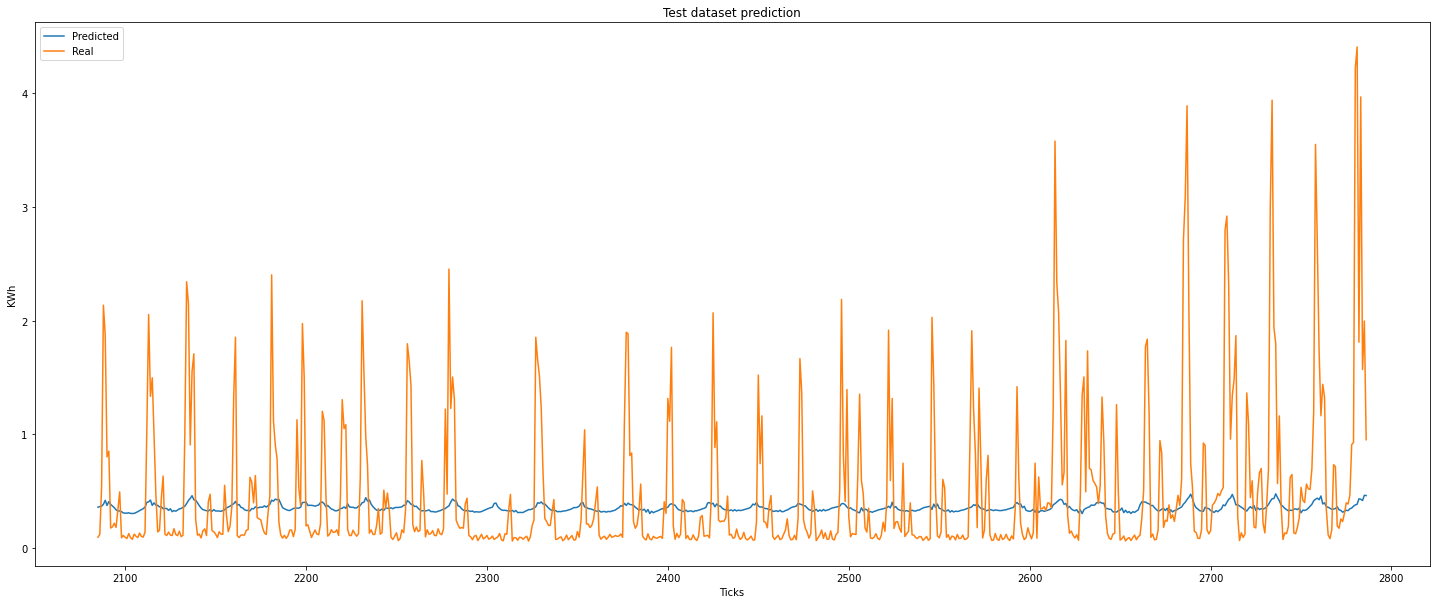

In [1079]:
# plot the outcome
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[:len(data_predict)], data_predict, label = 'Predicted')
plt.plot(weather_energy.index[:len(data_predict)],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()